# Estimacion de produccion de Aceite

Variables:

+ Produccion de Aceite y de Gas
+ 12 rezagos La produccion al tiempo $t_i$
+ estadisticos de tendencias:
    + Factores de declinacion
    + diferencia de produccion
    + ratio de produccion
    + conteo de subidas o bajadas en produccion
    + medias moviles
    + velocidad y aceleracion de produccion

+ Estadistica de produccion de aceite y gas:
    + desviacion estandar
    + mediana
    + minimo
    + maximo
    + quantiles 10,25,75,90
    + rango
+ tipo de equipo de perforacion
+ dummie de mes
+ clustering

El modelo consiste en generar una estimacion de la produccion del siguinte mes con informacion de 1 año de produccion

Se decidio generar los conjuntos de entrenamiento, prueba y validacion con un muestreo aleatorio, es decir, puede tomar cualquier fecha. En lugar de partir nuestros datos en temporadas. Esto con el fin de aprender tendencias de cualquier momento y actuales.

El notebook comienza con algunos descriptivos para saber el contexto de los datos. Posteriormente comenzamos con la preparacion de los datos y la generacion de variables. Una ves que generamos todas las variables se hace su analisis para quitar datos atipicos (outliers). Se genera un clustering para agrupar pozos y ayudarle al modelo a predecir mejor la produccion y se genera la variable correspondiente. Se analizan las variables con respecto a la variable dependiente analizando tendencias y correlaciones. Se entreno el modelo con 6K registros y se utilizo el algoritmo de Lightgbm que consiste en un GBM regularizado y con crecimiento por hojas en lugar de niveles de profundidad.

Se obtuvo un error de:

+ MEA: 11.15
+ RMSE: 34.81
+ $R^2$: 0.914
+ Residuo porcental promedio: -1.6% el signo menos significa que sobreestima el valor.

Las variables mas importantes son:
+ Produccion de barriles mes t-1
+ Diferencia de produccion de t-2 y t-1
+ desviacion estandar
+ ratio de la produccion de barriles al tiempo t-2 y t-1

Se genera un forecasting actualizando los valores reales de produccion por la estimacion y se predice mes con mes durante 10 años. Se observa que el modelo aprende la estacionalidad de produccion y predice adecuadamente durante 5 años. obteniendo un residuo promedio de 11.51 barriles mensuales.

In [1]:
#triada de la death
import pandas as pd
import numpy as np

#dataviz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import cufflinks

font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams[u'figure.figsize'] = (12,8)
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         }

plt.style.use('ggplot')

# Modelos
import lightgbm as lgb
from sklearn.cluster import KMeans
from sklearn.externals import joblib
from sklearn import metrics
# Interpretacion
import shap
from pdpbox import pdp, info_plots

#mis tools
import sys
sys.path.append('../serch_tools/')
import serch_tools as st

C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



In [2]:
aforos = pd.read_csv("datos/aforos.csv")
analisis_fluidos = pd.read_csv("datos/Analisis_fluidos.csv")
columna_geologica = pd.read_csv('datos/columna_geologica.csv')
eval_petrofisica = pd.read_csv('datos/eval_petrofisica.csv')
intervalo_disparado = pd.read_csv('datos/IntervalosDisparados.csv')
parametros_petrofisicos = pd.read_csv('datos/parametros_petrofisicos.csv')

In [3]:
datos_generales_pozos = pd.read_csv('datos/datos_generales_de_pozos.csv')
datos_generales_pozos['CLASIFICACION_LAHEE'] = datos_generales_pozos[
    'CLASIFICACION_LAHEE'].str[:6] + datos_generales_pozos[
    'CLASIFICACION_LAHEE'].str[8:]
datos_generales_pozos['CLASIFICACION_LAHEE'] = datos_generales_pozos['CLASIFICACION_LAHEE'].str.replace("/","-")

# Tabla DB_produccion_Moloacan

Tabla con historico de produccion en unidades de barriles mensuales

    Fecha - Fecha de registro
    Pozo -  Nombre del pozo
    Dias - Numero de dias del mes en curso
    Qo_mes_b - Numero de Barriles de Oil mensuales
    Qo_prom_mesbd - Promedio de barriles diarios Qo_mes_b / Dias
    Qg_mes_MMpc - 
    Qg_prom_mes_MMpcd - Qg_mes_MMpc / Dias
    Qw_mes_b - Numero de barriles de agua mensual
    Qw_prom_mes_bd - Promedio de barriles mensuales de agua  Qw_mes_b / Dias
    Fw_% - Porcentaje de Agua
    RGA_m3/m3 - Relacion Gas Aceite
    Dias_de_Operacion - Dias que estuvo operando la plataforma

In [4]:
db_prod_mol = pd.read_csv('datos/DB_prod_moloacan.csv')
db_prod_mol.columns = db_prod_mol.columns.str.replace(" ","_").str.replace(
    "(","").str.replace(")","").str.replace(".","").str.replace('á',"a").str.replace('é',"e").str.replace(
    'í',"i").str.replace('ó',"o").str.replace('ú',"u")
# transfromaciones
db_prod_mol['Qo_mes_b'] = db_prod_mol['Qo_mes_b'].str.replace(',', '').astype(float)
db_prod_mol['Qw_mes_b'] = db_prod_mol['Qw_mes_b'].str.replace(',', '').astype(float)
db_prod_mol['RGA_m3/m3'] = db_prod_mol['RGA_m3/m3'].str.replace(',', '').astype(float)
db_prod_mol["Pozo"] = db_prod_mol.Pozo.str.replace("Á","A")

In [5]:
db_prod_mol.columns

Index(['Fecha', 'Pozo', 'Dias', 'Qo_mes_b', 'Qo_prom_mesbd', 'Qg_mes_MMpc',
       'Qg_prom_mes_MMpcd', 'Qw_mes_b', 'Qw_prom_mes_bd', 'Fw_%', 'RGA_m3/m3',
       'Dias_de_Operacion'],
      dtype='object')

In [6]:
db_prod_mol['fecha_produccion'] = pd.to_datetime(db_prod_mol.Fecha, format="%d/%m/%Y")

In [7]:
db_prod_mol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20886 entries, 0 to 20885
Data columns (total 13 columns):
Fecha                20886 non-null object
Pozo                 20886 non-null object
Dias                 20886 non-null int64
Qo_mes_b             20886 non-null float64
Qo_prom_mesbd        20886 non-null float64
Qg_mes_MMpc          20886 non-null float64
Qg_prom_mes_MMpcd    20886 non-null float64
Qw_mes_b             20886 non-null float64
Qw_prom_mes_bd       20886 non-null float64
Fw_%                 20886 non-null float64
RGA_m3/m3            20886 non-null float64
Dias_de_Operacion    20886 non-null int64
fecha_produccion     20886 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(8), int64(2), object(2)
memory usage: 2.1+ MB


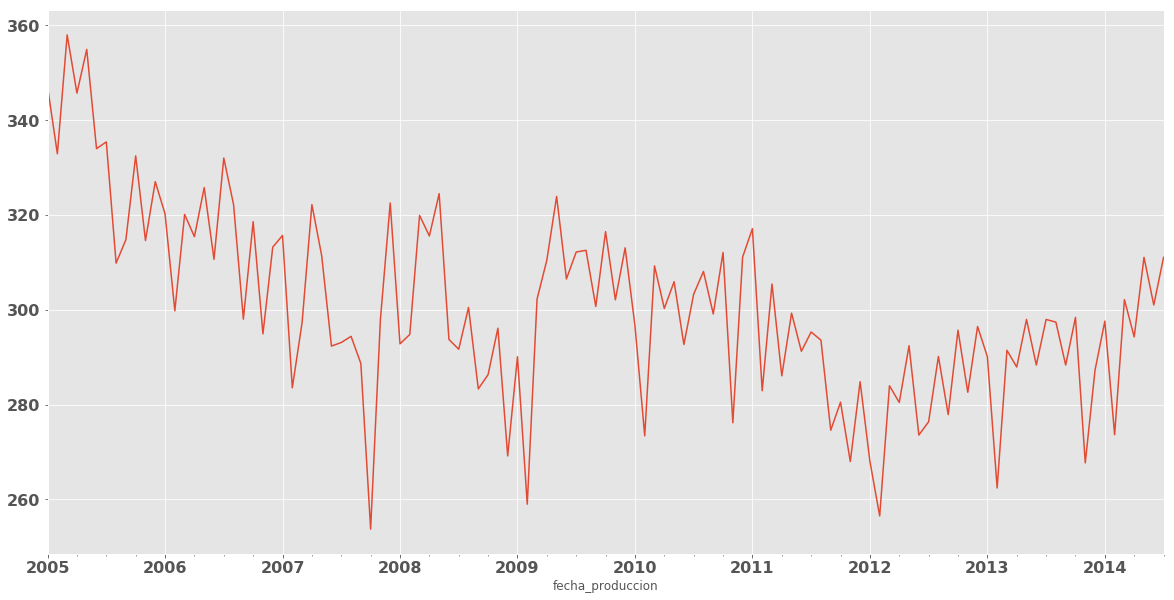

In [8]:
db_prod_mol[
    db_prod_mol.fecha_produccion>='2005-01-01'].groupby('fecha_produccion').Qo_mes_b.mean().plot(figsize=(20,10))

In [9]:
# SOLO SE TRABAJA CON 10 ANIOS Y SE QUITA UNA FECHA ATIPICA
db_prod_mol = db_prod_mol[(db_prod_mol.fecha_produccion > '2004-12-01')
#                           & (db_prod_mol.fecha_produccion != '2013-08-01')
#                           & (db_prod_mol.fecha_produccion != '2013-07-01') & (db_prod_mol.fecha_produccion != '2013-06-01')
                         ]

# Se estimara el numero de barriles mensuales

Se generan variables que expliquen la produccion en $P(t)$ con un historico de 12 meses con variables como $P(t-1), P(t-2), P(t-3)$

Se estima
$P(t) = \alpha + \beta_1 P(t-1)+ \beta_2 P(t-2)+ \beta_3 P(t-3)+ \beta_4 P(t-4)+ \beta_5 P(t-5)+ \beta_6 P(t-6) + \epsilon$

__Se hace una transformacion para hacer la serie estacionaria de manera que haremos el predict como:__

$\hat{y(t)} = \frac{y(t)}{y(t-1)} = f(x)$

Los rezagos ahora se calculan como $t-1/t-2$ y $t-2/t-3$

In [10]:
# # tabla (t-1)
t_1_real = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first()

# tabla (t)
t_real = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-1)

### check de y estacionaria

In [11]:
db_prod_mol.groupby(['Pozo','fecha_produccion'])['Qo_mes_b'].first().head()

Pozo           fecha_produccion
MOLOACAN-1004  2005-01-01          194.98
               2005-02-01          157.25
               2005-03-01          147.68
               2005-04-01          191.55
               2005-05-01          187.08
Name: Qo_mes_b, dtype: float64

In [12]:
t_real.head(5)

Pozo           fecha_produccion
MOLOACAN-1004  2005-01-01          157.25
               2005-02-01          147.68
               2005-03-01          191.55
               2005-04-01          187.08
               2005-05-01          134.89
Name: Qo_mes_b, dtype: float64

In [13]:
t_1_real.head()

Pozo           fecha_produccion
MOLOACAN-1004  2005-01-01          194.98
               2005-02-01          157.25
               2005-03-01          147.68
               2005-04-01          191.55
               2005-05-01          187.08
Name: Qo_mes_b, dtype: float64

In [14]:
Tsota = (t_real/t_1_real).dropna()

In [15]:
# tabla (t - 12)
t = Tsota

# tabla (t - 11)
t_1 = Tsota.shift(-1)

# tabla (t -10)
t_2 = Tsota.shift(-2)

# tabla (t - 9)
t_3 = Tsota.shift(-3)

# tabla (t - 8)
t_4 =Tsota.shift(-4)

# tabla (t -7)
t_5 = Tsota.shift(-5)

# tabla (t - 6)
t_6 = Tsota.shift(-6)

# tabla (t - 5)
t_7 = Tsota.shift(-7)

#tabla (t - 4) 
t_8 = Tsota.shift(-8)

#tabla (t - 3) 
t_9 = Tsota.shift(-9)

#tabla (t - 2) 
t_10 = Tsota.shift(-10)

#tabla (t - 1) 
t_11 = Tsota.shift(-11)

#tabla (t)  variable a estimar
t_12 = Tsota.shift(-12)

In [16]:
# # tabla (t-1)
t_1_real = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-12)

# tabla (t)
t_real = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-13)

Variables de produccion anterior, pensando que produciran semejante al mes anterior

In [17]:
df = pd.concat([t,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12,t_1_real,t_real],1).dropna()
df.columns = ['Produccion_barriles_t_12','Produccion_barriles_t_11','Produccion_barriles_t_10',
              'Produccion_barriles_t_9','Produccion_barriles_t_8','Produccion_barriles_t_7',
              'Produccion_barriles_t_6','Produccion_barriles_t_5','Produccion_barriles_t_4',
              'Produccion_barriles_t_3','Produccion_barriles_t_2','Produccion_barriles_t_1',
              'Produccion_barriles_t','y_real_oil_t_1','y_real_oil']

### check de y real y y real menos 1

In [18]:
190.96/148.13

1.289137919395126

In [19]:
160.17/148.13

1.0812799567947073

In [20]:
df.head()

Produccion_barriles_t_12  \
Pozo          fecha_produccion                             
MOLOACAN-1004 2005-01-01                        0.806493   
              2005-02-01                        0.939141   
              2005-03-01                        1.297061   
              2005-04-01                        0.976664   
              2005-05-01                        0.721028   

                                Produccion_barriles_t_11  \
Pozo          fecha_produccion                             
MOLOACAN-1004 2005-01-01                        0.939141   
              2005-02-01                        1.297061   
              2005-03-01                        0.976664   
              2005-04-01                        0.721028   
              2005-05-01                        0.865075   

                                Produccion_barriles_t_10  \
Pozo          fecha_produccion                             
MOLOACAN-1004 2005-01-01                        1.297061   
              2005-02-01                        0.976664   
              2005-03-01                        0.721028   
              2005-04-01                        0.865075   
              2005-05-01                        1.442369   

                                Produccion_barriles_t_9  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       0.976664   
              2005-02-01                       0.721028   
              2005-03-01                       0.865075   
              2005-04-01                       1.442369   
              2005-05-01                       0.886757   

                                Produccion_barriles_t_8  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       0.721028   
              2005-02-01                       0.865075   
              2005-03-01                       1.442369   
              2005-04-01                       0.886757   
              2005-05-01                       1.057420   

                                Produccion_barriles_t_7  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       0.865075   
              2005-02-01                       1.442369   
              2005-03-01                       0.886757   
              2005-04-01                       1.057420   
              2005-05-01                       1.149537   

                                Produccion_barriles_t_6  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       1.442369   
              2005-02-01                       0.886757   
              2005-03-01                       1.057420   
              2005-04-01                       1.149537   
              2005-05-01                       1.052585   

                                Produccion_barriles_t_5  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       0.886757   
              2005-02-01                       1.057420   
              2005-03-01                       1.149537   
              2005-04-01                       1.052585   
              2005-05-01                       0.775712   

                                Produccion_barriles_t_4  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       1.057420   
              2005-02-01                       1.149537   
              2005-03-01                       1.052585   
              2005-04-01                       0.775712   
              2005-05-01                       1.081280   

                                Produccion_barriles_t_3  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       1.149537   
              2005-02-01                       1.052585   
              2005-03-01                       0.

In [21]:
db_prod_mol['f_prod'] = db_prod_mol.fecha_produccion

In [22]:
#tabla (t)  fecha real
fecha_de_y = db_prod_mol.groupby(['Pozo','fecha_produccion']).f_prod.first().shift(-13)

In [23]:
df = pd.merge(df, pd.DataFrame(fecha_de_y), left_index=True, right_index=True)
df.head()

Produccion_barriles_t_12  \
Pozo          fecha_produccion                             
MOLOACAN-1004 2005-01-01                        0.806493   
              2005-02-01                        0.939141   
              2005-03-01                        1.297061   
              2005-04-01                        0.976664   
              2005-05-01                        0.721028   

                                Produccion_barriles_t_11  \
Pozo          fecha_produccion                             
MOLOACAN-1004 2005-01-01                        0.939141   
              2005-02-01                        1.297061   
              2005-03-01                        0.976664   
              2005-04-01                        0.721028   
              2005-05-01                        0.865075   

                                Produccion_barriles_t_10  \
Pozo          fecha_produccion                             
MOLOACAN-1004 2005-01-01                        1.297061   
              2005-02-01                        0.976664   
              2005-03-01                        0.721028   
              2005-04-01                        0.865075   
              2005-05-01                        1.442369   

                                Produccion_barriles_t_9  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       0.976664   
              2005-02-01                       0.721028   
              2005-03-01                       0.865075   
              2005-04-01                       1.442369   
              2005-05-01                       0.886757   

                                Produccion_barriles_t_8  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       0.721028   
              2005-02-01                       0.865075   
              2005-03-01                       1.442369   
              2005-04-01                       0.886757   
              2005-05-01                       1.057420   

                                Produccion_barriles_t_7  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       0.865075   
              2005-02-01                       1.442369   
              2005-03-01                       0.886757   
              2005-04-01                       1.057420   
              2005-05-01                       1.149537   

                                Produccion_barriles_t_6  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       1.442369   
              2005-02-01                       0.886757   
              2005-03-01                       1.057420   
              2005-04-01                       1.149537   
              2005-05-01                       1.052585   

                                Produccion_barriles_t_5  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       0.886757   
              2005-02-01                       1.057420   
              2005-03-01                       1.149537   
              2005-04-01                       1.052585   
              2005-05-01                       0.775712   

                                Produccion_barriles_t_4  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       1.057420   
              2005-02-01                       1.149537   
              2005-03-01                       1.052585   
              2005-04-01                       0.775712   
              2005-05-01                       1.081280   

                                Produccion_barriles_t_3  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       1.149537   
              2005-02-01                       1.052585   
              2005-03-01                       0.

Listo ya se le pego el valor real y el anterior para poder regresar durante la prediccion

In [24]:
df['diff_t_12_t_11'] = df.Produccion_barriles_t_12 - df.Produccion_barriles_t_11
df['diff_t_11_t_10'] = df.Produccion_barriles_t_11 - df.Produccion_barriles_t_10
df['diff_t_10_t_9'] = df.Produccion_barriles_t_10 - df.Produccion_barriles_t_9
df['diff_t_9_t_8'] = df.Produccion_barriles_t_9 - df.Produccion_barriles_t_8
df['diff_t_8_t_7'] = df.Produccion_barriles_t_8 - df.Produccion_barriles_t_7
df['diff_t_7_t_6'] = df.Produccion_barriles_t_7 - df.Produccion_barriles_t_6
df['diff_t_6_t_5'] = df.Produccion_barriles_t_6 - df.Produccion_barriles_t_5
df['diff_t_5_t_4'] = df.Produccion_barriles_t_5 - df.Produccion_barriles_t_4
df['diff_t_4_t_3'] = df.Produccion_barriles_t_4 - df.Produccion_barriles_t_3
df['diff_t_3_t_2'] = df.Produccion_barriles_t_3 - df.Produccion_barriles_t_2

# cambio en la produccion
df['diff_t_6_t_1'] = df.Produccion_barriles_t_6 - df.Produccion_barriles_t_1
df['diff_t_5_t_1'] = df.Produccion_barriles_t_5 - df.Produccion_barriles_t_1
df['diff_t_4_t_1'] = df.Produccion_barriles_t_4 - df.Produccion_barriles_t_1
df['diff_t_3_t_1'] = df.Produccion_barriles_t_3 - df.Produccion_barriles_t_1
df['diff_t_2_t_1'] = df.Produccion_barriles_t_2 - df.Produccion_barriles_t_1


df['aceleracion_de_produccion _t3t2_t2t1'] = df['diff_t_3_t_2'] - df['diff_t_2_t_1']
df['aceleracion_de_produccion _t4t3_t2t1'] = df['diff_t_4_t_3'] - df['diff_t_2_t_1']

In [25]:
df['ratio_t_12_t_11'] = df.Produccion_barriles_t_12 / df.Produccion_barriles_t_11
df['ratio_t_11_t_10'] = df.Produccion_barriles_t_11 / df.Produccion_barriles_t_10
df['ratio_t_10_t_9'] = df.Produccion_barriles_t_10 / df.Produccion_barriles_t_9
df['ratio_t_9_t_8'] = df.Produccion_barriles_t_9 / df.Produccion_barriles_t_8
df['ratio_t_8_t_7'] = df.Produccion_barriles_t_8 / df.Produccion_barriles_t_7
df['ratio_t_7_t_6'] = df.Produccion_barriles_t_7 / df.Produccion_barriles_t_6
df['ratio_t_6_t_5'] = df.Produccion_barriles_t_6 / df.Produccion_barriles_t_5
df['ratio_t_5_t_4'] = df.Produccion_barriles_t_5 / df.Produccion_barriles_t_4
df['ratio_t_4_t_3'] = df.Produccion_barriles_t_4 / df.Produccion_barriles_t_3
df['ratio_t_3_t_2'] = df.Produccion_barriles_t_3 / df.Produccion_barriles_t_2

# cambio en la produccion
df['ratio_t_6_t_1'] = df.Produccion_barriles_t_6 / df.Produccion_barriles_t_1
df['ratio_t_5_t_1'] = df.Produccion_barriles_t_5 / df.Produccion_barriles_t_1
df['ratio_t_4_t_1'] = df.Produccion_barriles_t_4 / df.Produccion_barriles_t_1
df['ratio_t_3_t_1'] = df.Produccion_barriles_t_3 / df.Produccion_barriles_t_1
df['ratio_t_2_t_1'] = df.Produccion_barriles_t_2 / df.Produccion_barriles_t_1

In [26]:
df['subio_t_12_t_11'] = np.where(df.diff_t_12_t_11 < 0,1,0)
df['subio_t_11_t_10'] = np.where(df.diff_t_11_t_10 < 0,1,0)
df['subio_t_10_t_9'] = np.where(df.diff_t_10_t_9 < 0,1,0)
df['subio_t_9_t_8'] = np.where(df.diff_t_9_t_8 < 0,1,0)
df['subio_t_8_t_7'] = np.where(df.diff_t_8_t_7 < 0,1,0)
df['subio_t_7_t_6'] = np.where(df.diff_t_7_t_6 < 0,1,0)
df['subio_t_6_t_5'] = np.where(df.diff_t_6_t_5 < 0,1,0)
df['subio_t_5_t_4'] = np.where(df.diff_t_5_t_4 < 0,1,0)
df['subio_t_4_t_3'] = np.where(df.diff_t_4_t_3 < 0,1,0)
df['subio_t_3_t_2'] = np.where(df.diff_t_3_t_2 < 0,1,0)
df['subio_t_2_t_1'] = np.where(df.diff_t_2_t_1 < 0,1,0)
df['num_subidas'] = df[['subio_t_12_t_11','subio_t_11_t_10','subio_t_10_t_9','subio_t_9_t_8','subio_t_8_t_7','subio_t_7_t_6',
                        'subio_t_6_t_5','subio_t_5_t_4','subio_t_4_t_3','subio_t_3_t_2','subio_t_2_t_1']].sum(1)

df['bajo_t_12_t_11'] = np.where(df.diff_t_12_t_11 > 0,1,0)
df['bajo_t_11_t_10'] = np.where(df.diff_t_11_t_10 > 0,1,0)
df['bajo_t_10_t_9'] = np.where(df.diff_t_10_t_9 > 0,1,0)
df['bajo_t_9_t_8'] = np.where(df.diff_t_9_t_8 > 0,1,0)
df['bajo_t_8_t_7'] = np.where(df.diff_t_8_t_7 > 0,1,0)
df['bajo_t_7_t_6'] = np.where(df.diff_t_7_t_6 > 0,1,0)
df['bajo_t_6_t_5'] = np.where(df.diff_t_6_t_5 > 0,1,0)
df['bajo_t_5_t_4'] = np.where(df.diff_t_5_t_4 > 0,1,0)
df['bajo_t_4_t_3'] = np.where(df.diff_t_4_t_3 > 0,1,0)
df['bajo_t_3_t_2'] = np.where(df.diff_t_3_t_2 > 0,1,0)
df['bajo_t_2_t_1'] = np.where(df.diff_t_2_t_1 > 0,1,0)
df['num_bajadas'] = df[['bajo_t_12_t_11','bajo_t_11_t_10','bajo_t_10_t_9','bajo_t_9_t_8','bajo_t_8_t_7','bajo_t_7_t_6',
                        'bajo_t_6_t_5','bajo_t_5_t_4','bajo_t_4_t_3','bajo_t_3_t_2','bajo_t_2_t_1']].sum(1)

Variables de diferencia entre periodos, como una velocidad de produccion entre un mes y otro.

In [27]:
# desviacion estandar
df['std_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].std(1)
# mediana
df['median_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                           'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].median(1)
# minimo
df['min_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].min(1)
#quantiles
df['q75_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.75,axis=1)
df['q25_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.25,axis=1)
df['q90_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.90,axis=1)
df['q10_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.10,axis=1)
#maximo
df['max_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].max(1)

#rango
df['rango_t12_t1'] = df['max_t_12_t_1'] - df['min_t_12_t_1']

Variables estadisticas sobre el historico de 6 meses.
+ std si varia mucho puede que ayude a predecir la produccion
+ median, mean es probable que produzca al menos el promedio que ha producido antes
+ min Si ya paso por un bache de produccion puede indicarnos si seguira ahi... NO ESTOY SEGURO
+ max Si esta en un pico de produccion o ya lo paso, al menos no va a sobrepasar este valor
+  rango Acota la produccion esperada para no sobreestimar
+ quantiles en 12 meses

In [28]:
# medias moviles
df['media_movil_t_2_t_1'] = df[['Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
df['media_movil_t_3_t_1'] = df[[ 'Produccion_barriles_t_3',
                                'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
df['media_movil_t_4_t_1'] = df[['Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
df['media_movil_t_5_t_1'] = df[['Produccion_barriles_t_5',
                               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)

df['media_movil_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
                               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)

df['media_movil_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)

Se crean variables de medias moviles

In [29]:
df['produccion_anual'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].sum(1)

Suma de produccion anual

In [30]:
df['Tasa_Declinacion_anual'] = - (np.log(df.Produccion_barriles_t_12/df.Produccion_barriles_t_1))/12
df['Tasa_Declinacion_Efectiva'] = - (df.Produccion_barriles_t_12 - df.Produccion_barriles_t_1)/df.Produccion_barriles_t_12

Tasas de declinacion anual $D=-\frac{ln(\frac{q_{12}}{q_{1}})}{12}$

Tasas de declinacion efectiva $D=-\frac{(q_{12}-q_{1})}{q_{12}}$

Referencia http://www.portaldelpetroleo.com/2012/07/bpd-curvas-de-declinacion-de-produccion.html

In [31]:
df['dummi_pico_bajo'] = np.where(df.media_movil_t_6_t_1 - 4*df.std_t_12_t_1 > df.Produccion_barriles_t,1,0)

In [32]:
df[df.dummi_pico_bajo==1].shape

(187, 91)

In [33]:
df = df[df.dummi_pico_bajo!=1]

# variables del modelo de gas

In [34]:
# # tabla (t-1)
t_1 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first()

# tabla (t)
t = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-1)

In [35]:
Tsota = (t/t_1).dropna()

In [36]:
# tabla (t - 12)
t = Tsota

# tabla (t - 11)
t_1 = Tsota.shift(-1)

# tabla (t -10)
t_2 = Tsota.shift(-2)

# tabla (t - 9)
t_3 = Tsota.shift(-3)

# tabla (t - 8)
t_4 =Tsota.shift(-4)

# tabla (t -7)
t_5 = Tsota.shift(-5)

# tabla (t - 6)
t_6 = Tsota.shift(-6)

# tabla (t - 5)
t_7 = Tsota.shift(-7)

#tabla (t - 4) 
t_8 = Tsota.shift(-8)

#tabla (t - 3) 
t_9 = Tsota.shift(-9)

#tabla (t - 2) 
t_10 = Tsota.shift(-10)

#tabla (t - 1) 
t_11 = Tsota.shift(-11)

#tabla (t)  variable a estimar
t_12 = Tsota.shift(-12)

In [37]:
# # tabla (t-1)
t_1_real = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-12)

# tabla (t)
t_real = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-13)

In [38]:
t_gas = pd.concat([t,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12,t_1_real,t_real],1).dropna()
t_gas.columns = ['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
              'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
              'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1',
              'Produccion_gasMMpc_t','y_real_gas_t_1','y_real_gas']

In [39]:
df = pd.merge(df,t_gas, right_index=True, left_index=True).dropna()

In [40]:
df.shape

(11371, 106)

In [41]:
# desviacion estandar
df['stdgas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
              'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
              'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].std(1)
# mediana
df['mediangas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
              'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
              'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].median(1)
# minimo
df['mingas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
              'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
              'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].min(1)
#quantiles
df['q75gas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
              'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
              'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].quantile(0.75,axis=1)
df['q25gas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
              'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
              'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].quantile(0.25,axis=1)
df['q90gas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
              'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
              'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].quantile(0.90,axis=1)
df['q10gas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
              'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
              'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].quantile(0.10,axis=1)
#maximo
df['maxgas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
              'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
              'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].max(1)

#rango
df['rangogas_t12_t1'] = df['maxgas_t_12_t_1'] - df['mingas_t_12_t_1']

In [42]:
# medias moviles
df['media_movilgas_t_2_t_1'] = df[['Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].mean(1)
df['media_movilgas_t_3_t_1'] = df[['Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].mean(1)
df['media_movilgas_t_4_t_1'] = df[['Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].mean(1)
df['media_movilgas_t_5_t_1'] = df[['Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].mean(1)

df['media_movilgas_t_6_t_1'] = df[['Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].mean(1)

df['media_movilgas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
              'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
              'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].mean(1)

## variable dummie de mes

In [43]:
# tabla dummies_month
dummi_month = pd.get_dummies(df.f_prod.dt.month, prefix='month')
dummi_month.head()

month_1  month_2  month_3  month_4  month_5  \
Pozo          fecha_produccion                                                
MOLOACAN-1004 2005-01-01              0        1        0        0        0   
              2005-02-01              0        0        1        0        0   
              2005-03-01              0        0        0        1        0   
              2005-04-01              0        0        0        0        1   
              2005-05-01              0        0        0        0        0   

                                month_6  month_7  month_8  month_9  month_10  \
Pozo          fecha_produccion                                                 
MOLOACAN-1004 2005-01-01              0        0        0        0         0   
              2005-02-01              0        0        0        0         0   
              2005-03-01              0        0        0        0         0   
              2005-04-01              0        0        0        0         0   
              2005-05-01              1        0        0        0         0   

                                month_11  month_12  
Pozo          fecha_produccion                      
MOLOACAN-1004 2005-01-01               0         0  
              2005-02-01               0         0  
              2005-03-01               0         0  
              2005-04-01               0         0  
              2005-05-01               0         0

In [44]:
df = pd.merge(df, dummi_month, right_index=True, left_index=True)

# Latitud y longitud

ojo caracteriza al pozo, mejor no meterla

In [45]:
lat_lon_pozo = datos_generales_pozos.groupby('NOMBRE_DE_POZO')[['LATITUD','LONGITUD']].first()
lat_lon_pozo.reset_index(inplace=True)
lat_lon_pozo.columns = ['Pozo','latitud', 'longitud']
lat_lon_pozo.head()

,Pozo,latitud,longitud
0,MOLOACAN-1,17.987072,-94.381714
1,MOLOACAN-101,17.982659,-94.369994
2,MOLOACAN-102,17.982043,-94.367304
3,MOLOACAN-102A,17.982088,-94.367397
4,MOLOACAN-11,17.986597,-94.373105


In [46]:
df_train = df.reset_index().merge(lat_lon_pozo, how='left',on='Pozo').dropna()

In [47]:
df_train.head()

,Pozo,fecha_produccion,Produccion_barriles_t_12,Produccion_barriles_t_11,Produccion_barriles_t_10,Produccion_barriles_t_9,Produccion_barriles_t_8,Produccion_barriles_t_7,Produccion_barriles_t_6,Produccion_barriles_t_5,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,latitud,longitud
117,MOLOACAN-111,2005-01-01,0.950135,1.056198,0.661237,0.702259,0.336793,9.306626,1.131854,1.005910,...,0,0,1,0,0,0,0,0,17.985929,-94.370707
118,MOLOACAN-111,2005-02-01,1.056198,0.661237,0.702259,0.336793,9.306626,1.131854,1.005910,1.093183,...,0,0,0,1,0,0,0,0,17.985929,-94.370707
119,MOLOACAN-111,2005-03-01,0.661237,0.702259,0.336793,9.306626,1.131854,1.005910,1.093183,0.978052,...,0,0,0,0,0,0,0,0,17.985929,-94.370707
120,MOLOACAN-111,2005-04-01,0.702259,0.336793,9.306626,1.131854,1.005910,1.093183,0.978052,1.094987,...,0,0,0,0,0,0,0,0,17.985929,-94.370707
121,MOLOACAN-111,2005-06-01,0.336793,9.306626,1.131854,1.005910,1.093183,0.978052,1.094987,0.600447,...,0,0,0,0,0,0,0,0,17.985929,-94.370707


In [48]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_12',
       'Produccion_barriles_t_11', 'Produccion_barriles_t_10',
       'Produccion_barriles_t_9', 'Produccion_barriles_t_8',
       'Produccion_barriles_t_7', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5',
       ...
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'latitud', 'longitud'],
      dtype='object', length=137)

# calculo de numero de plataformas cercanas

In [49]:
lat_lon_pozo.head()

,Pozo,latitud,longitud
0,MOLOACAN-1,17.987072,-94.381714
1,MOLOACAN-101,17.982659,-94.369994
2,MOLOACAN-102,17.982043,-94.367304
3,MOLOACAN-102A,17.982088,-94.367397
4,MOLOACAN-11,17.986597,-94.373105


In [50]:
#Funcion par calcular la distiancia de un punto a otro
import math
from math import sin, cos, sqrt, atan2, radians
def haversine(lon1, lat1, lon2, lat2):
    R = 6373.0
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [51]:
db_prod_mol.columns

Index(['Fecha', 'Pozo', 'Dias', 'Qo_mes_b', 'Qo_prom_mesbd', 'Qg_mes_MMpc',
       'Qg_prom_mes_MMpcd', 'Qw_mes_b', 'Qw_prom_mes_bd', 'Fw_%', 'RGA_m3/m3',
       'Dias_de_Operacion', 'fecha_produccion', 'f_prod'],
      dtype='object')

In [52]:
df_fecha_creacion = db_prod_mol.groupby('Pozo').fecha_produccion.min().reset_index()
df_fecha_creacion.columns = ['Pozo','primera_fecha_produccion']

In [53]:
lat_lon_pozo = lat_lon_pozo.merge(df_fecha_creacion,on='Pozo')
lat_lon_pozo.head()

,Pozo,latitud,longitud,primera_fecha_produccion
0,MOLOACAN-111,17.985929,-94.370707,2005-01-01
1,MOLOACAN-112,17.985046,-94.367871,2005-01-01
2,MOLOACAN-121,17.987249,-94.368291,2005-05-01
3,MOLOACAN-132,17.989190,-94.366750,2006-06-01
4,MOLOACAN-1400,17.960963,-94.382869,2005-01-01


In [54]:
# dist = []
# # lat_lon = lat_lon_pozo.valuesm PENDIENTE OPTIMIZARLA CON NUMPY ARRAYS
# for i in range(lat_lon_pozo.shape[0]):
#     for j in range(lat_lon_pozo.shape[0]):
#         if i != j and lat_lon_pozo.loc[i,'primera_fecha_produccion'] >= lat_lon_pozo.loc[j,'primera_fecha_produccion']: 
#             # se subestimada la construccion para
#             # no regarla pero estaria bien pegarle por fecha donde uno se para
#             distancia = haversine(lat_lon_pozo.loc[i,'longitud'], lat_lon_pozo.loc[i,'latitud'],
#                               lat_lon_pozo.loc[j,'longitud'],lat_lon_pozo.loc[j,'latitud'])
#             dist.append([lat_lon_pozo.iloc[i].Pozo,lat_lon_pozo.iloc[j].Pozo,distancia])

In [55]:
# df_dist = pd.DataFrame(dist)
# df_dist.columns = ['Pozo','pozo2','distancia']
# df_dist['es_cercano'] = np.where(df_dist.distancia <= 1,1,0)

In [56]:
# df_dist.distancia.hist(bins=100)

In [57]:
# df_num_pozos_cercanos = pd.DataFrame(df_dist.groupby('Pozo').es_cercano.sum()).reset_index()
# df_num_pozos_cercanos.columns = ['Pozo','num_pozos_a_menos_de_1km']
# df_train = df_train.merge(df_num_pozos_cercanos, how='left',on='Pozo').dropna()

In [58]:
df_train.head()

,Pozo,fecha_produccion,Produccion_barriles_t_12,Produccion_barriles_t_11,Produccion_barriles_t_10,Produccion_barriles_t_9,Produccion_barriles_t_8,Produccion_barriles_t_7,Produccion_barriles_t_6,Produccion_barriles_t_5,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,latitud,longitud
117,MOLOACAN-111,2005-01-01,0.950135,1.056198,0.661237,0.702259,0.336793,9.306626,1.131854,1.005910,...,0,0,1,0,0,0,0,0,17.985929,-94.370707
118,MOLOACAN-111,2005-02-01,1.056198,0.661237,0.702259,0.336793,9.306626,1.131854,1.005910,1.093183,...,0,0,0,1,0,0,0,0,17.985929,-94.370707
119,MOLOACAN-111,2005-03-01,0.661237,0.702259,0.336793,9.306626,1.131854,1.005910,1.093183,0.978052,...,0,0,0,0,0,0,0,0,17.985929,-94.370707
120,MOLOACAN-111,2005-04-01,0.702259,0.336793,9.306626,1.131854,1.005910,1.093183,0.978052,1.094987,...,0,0,0,0,0,0,0,0,17.985929,-94.370707
121,MOLOACAN-111,2005-06-01,0.336793,9.306626,1.131854,1.005910,1.093183,0.978052,1.094987,0.600447,...,0,0,0,0,0,0,0,0,17.985929,-94.370707


# Variable de tecnologia
Se le pega el nombre del equipo de perforacion para saber si es mejor o peor para la produccion

In [59]:
# pegar a pozo nombre_equipo_perfo
nombre_equi_perfo = pd.DataFrame(datos_generales_pozos.groupby(
    'NOMBRE_DE_POZO')['NOMBRE_EQUIPO_DE_PERFORACION'].first())
nombre_equi_perfo.reset_index(inplace=True)
nombre_equi_perfo.columns = ['Pozo','equipo_perforacion']
# se encontraron inconsistencias en la info
nombre_equi_perfo["equipo_perforacion"] = nombre_equi_perfo.equipo_perforacion.str.replace(
    "PM5597-","PM-5597").str.replace(
    "PM.-5597","PM-5597").str.replace(
    "PM.5599","PM-5599")
nombre_equi_perfo.head()

,Pozo,equipo_perforacion
0,MOLOACAN-1,SIN INFORMACION
1,MOLOACAN-101,SIN INFORMACION
2,MOLOACAN-102,SIN INFORMACION
3,MOLOACAN-102A,PM-5597
4,MOLOACAN-11,PM-111


In [60]:
df_train = df_train.merge(nombre_equi_perfo, how='left',on='Pozo').dropna()

In [61]:
df_train = pd.get_dummies(df_train, columns=['equipo_perforacion'])

In [62]:
df_train.shape

(11093, 150)

# variable clasificaccion LAHEE
La Clasificación Lahee, los pozos pueden ser identificados como:
+ Pozo Exploratorio
+ Pozos Productores
+ Pozos no Productores (Secos)
+ Pozos de Desarrollo
+ Pozo de Avanzada

Codigos

    07-07-01 - Pozo de desarrollo, productor aceite
    07-07-06 - Pozo de desarrollo, improductivo, invadido de agua salada
    07-07-13 - 07 Pozo de desarrollo
    07-07-04 - Pozo de desarrollo, productor incosteable
    07-07-07 - Pozo de desarrollo, improductivo seco
    04-04-01 - Pozo en busca de nueva acumulacion en campo ya productor, productor de aceite
    07-01-00 - 07 Pozo de desarrollo
    04-04-06 - Pozo en busca de nueva acumulacion en campo ya productor, improductivo, invadido de agua salada
    01-01-06 - Pozo en busca de nueva acumulacion, improductivo, invadido de agua salada
    SIN INFORMACION

Referencia de codigos https://bndh.gob.do/wp-content/uploads/2016/04/4.3-MEM-BNDH-RD-Tercer-Informe-de-Avances_v2-1.pdf


NO VALE LA PENA TODOS LOS POZOS SON DE DESARROLLO O SIN INFORMACION

In [63]:
# clasifi_lahee = pd.DataFrame(datos_generales_pozos.groupby(
#     'NOMBRE_DE_POZO')['CLASIFICACION_LAHEE'].first())
# clasifi_lahee.reset_index(inplace=True)
# clasifi_lahee.columns = ['Pozo','clasificacion_lahee']
# clasifi_lahee.head()

In [64]:
# df_train = df_train.merge(clasifi_lahee, how='left',on='Pozo').dropna()

In [65]:
# df_train = pd.get_dummies(df_train, columns=['clasificacion_lahee'])

In [66]:
# df_train.shape

In [67]:
# df_train.head()

# Saturacion y porosidad 
FALTA BITACORA PARA PEGARLE VARIABLES GEOLOGICAS

# HACE FALTA UNA BITACORA DE COMO FUERON SUBIENDO PARA PODER PEGAR TODA ESTA INFORMACION

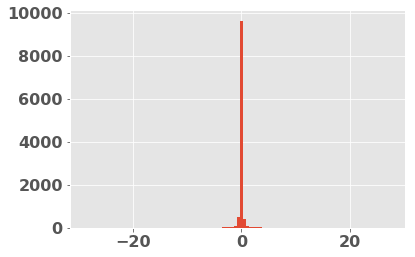

In [68]:
df_train.diff_t_2_t_1.hist(bins=100)

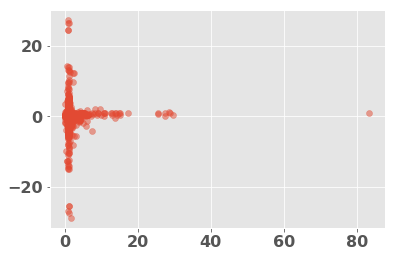

In [69]:
plt.scatter(df_train.Produccion_barriles_t, df_train.diff_t_2_t_1, alpha=0.5)

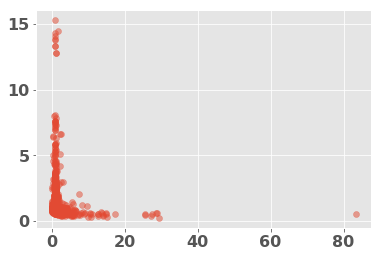

In [70]:
plt.scatter(df_train.Produccion_barriles_t, df_train.media_movil_t_2_t_1, alpha=0.5)

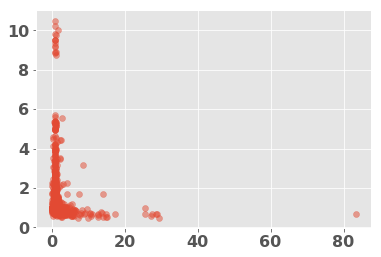

In [71]:
plt.scatter(df_train.Produccion_barriles_t, df_train.media_movil_t_3_t_1, alpha=0.5)

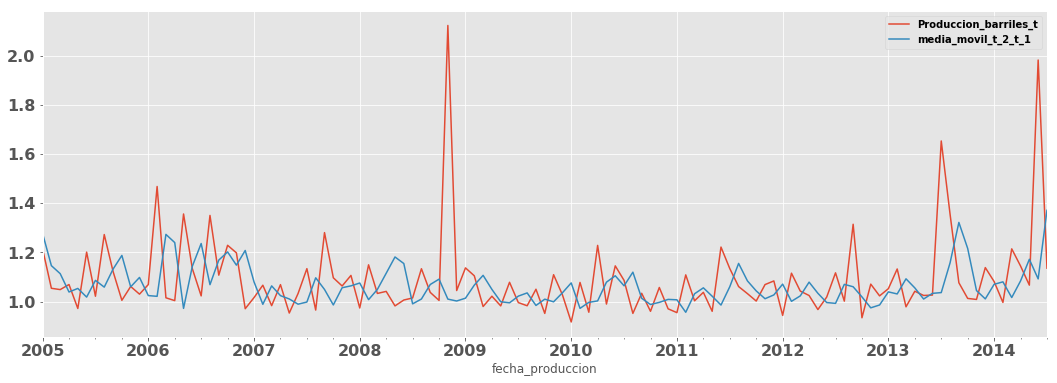

In [72]:
df_train.groupby('fecha_produccion')[['Produccion_barriles_t','media_movil_t_2_t_1']].mean().plot(figsize=(18,6))

# pendiente pico historico

In [73]:
# df_d_prod = db_prod_mol.groupby(['Pozo','fecha_produccion']).f_prod.first().shift(-6).reset_index()
# db_prod_mol['fecha_y'] = df_d_prod.f_prod

In [74]:
# for i in db_prod_mol.groupby('Pozo')[['Qo_mes_b','fecha_produccion','fecha_y']]:
#     print(i[0])
#     print(i[1][i[1].fecha_produccion >= i[1].fecha_y])

In [75]:
# y_temp = []
# for i in sample_prod_data.groupby('API')['Liquid']:
# #     print(i[0])
# #     print(i[1][i[1].index >= idx_prod_max_api[i[0]]].sum())
#     y_temp.append([i[0], i[1][i[1].index >= idx_prod_max_api[i[0]]].sum()])

In [76]:
# idx_prod_max_api = prod_data_train.groupby('API').Liquid.idxmax()

In [77]:
# # AQUI SE CREA LA Y (se puede hacer lista de comprension)
# pico_temp = []
# for i in db_prod_mol.groupby('Pozo')['Qo_mes_b']:
#     pico_temp.append([i[0], i[1][i[1].fecha_produccion >= idx_prod_max_api[i[0]]].sum()])

In [78]:
# db_prod_mol.columns

In [79]:
# db_prod_mol.groupby('Pozo')[['fecha_produccion','f_prod']].last()

In [80]:
# db_prod_mol.groupby(
#     ['Pozo','fecha_produccion'])

In [81]:
df_train.shape

(11093, 150)

## Quitamos Outliers

In [82]:
np.array(df_train.columns)

array(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_12',
       'Produccion_barriles_t_11', 'Produccion_barriles_t_10',
       'Produccion_barriles_t_9', 'Produccion_barriles_t_8',
       'Produccion_barriles_t_7', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t',
       'y_real_oil_t_1', 'y_real_oil', 'f_prod', 'diff_t_12_t_11',
       'diff_t_11_t_10', 'diff_t_10_t_9', 'diff_t_9_t_8', 'diff_t_8_t_7',
       'diff_t_7_t_6', 'diff_t_6_t_5', 'diff_t_5_t_4', 'diff_t_4_t_3',
       'diff_t_3_t_2', 'diff_t_6_t_1', 'diff_t_5_t_1', 'diff_t_4_t_1',
       'diff_t_3_t_1', 'diff_t_2_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'ratio_t_12_t_11',
       'ratio_t_11_t_10', 'ratio_t_10_t_9', 'ratio_t_9_t_8',
       'ratio_t_8_t_7', 'ratio_t_7_t_6', 'ratio_t_6_t_5', 'ratio_t_5_t_4',


In [83]:
df_train = df_train[df_train.Produccion_barriles_t > df_train.Produccion_barriles_t.quantile(0.005)]
df_train = df_train[df_train.Produccion_barriles_t_1 > df_train.Produccion_barriles_t_1.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_2 > df_train.Produccion_barriles_t_2.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_3 > df_train.Produccion_barriles_t_3.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_4 > df_train.Produccion_barriles_t_4.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_5 > df_train.Produccion_barriles_t_5.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_6 > df_train.Produccion_barriles_t_6.quantile(0.001)]

In [84]:
df_train = df_train[df_train.Produccion_barriles_t < df_train.Produccion_barriles_t.quantile(0.9)]

In [85]:
df_train = df_train[df_train.Produccion_barriles_t_1 < df_train.Produccion_barriles_t_1.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_2 < df_train.Produccion_barriles_t_2.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_3 < df_train.Produccion_barriles_t_3.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_4 < df_train.Produccion_barriles_t_4.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_5 < df_train.Produccion_barriles_t_5.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_6 < df_train.Produccion_barriles_t_6.quantile(0.99)]

In [86]:
df_train = df_train[df_train.diff_t_2_t_1 > df_train.diff_t_2_t_1.quantile(0.005)]
df_train = df_train[df_train.diff_t_2_t_1 < df_train.diff_t_2_t_1.quantile(0.99)]

In [87]:
df_train.reset_index(inplace=True, drop=True)

In [88]:
df_train.shape

(9145, 150)

In [89]:
df_train = df_train[df_train.Produccion_gasMMpc_t > df_train.Produccion_gasMMpc_t.quantile(0.005)]
df_train = df_train[df_train.Produccion_gasMMpc_t_1 > df_train.Produccion_gasMMpc_t_1.quantile(0.001)]
df_train = df_train[df_train.Produccion_gasMMpc_t_2> df_train.Produccion_gasMMpc_t_2.quantile(0.001)]
df_train = df_train[df_train.Produccion_gasMMpc_t_3> df_train.Produccion_gasMMpc_t_3.quantile(0.001)]
df_train = df_train[df_train.Produccion_gasMMpc_t_4> df_train.Produccion_gasMMpc_t_4.quantile(0.001)]
df_train = df_train[df_train.Produccion_gasMMpc_t_5> df_train.Produccion_gasMMpc_t_5.quantile(0.001)]
df_train = df_train[df_train.Produccion_gasMMpc_t_6> df_train.Produccion_gasMMpc_t_6.quantile(0.001)]

In [90]:
df_train = df_train[df_train.Produccion_gasMMpc_t < df_train.Produccion_gasMMpc_t.quantile(0.99)]

In [91]:
df_train = df_train[df_train.Produccion_gasMMpc_t_1 < df_train.Produccion_gasMMpc_t_1.quantile(0.99)]
df_train = df_train[df_train.Produccion_gasMMpc_t_2 < df_train.Produccion_gasMMpc_t_2.quantile(0.99)]
df_train = df_train[df_train.Produccion_gasMMpc_t_3 < df_train.Produccion_gasMMpc_t_3.quantile(0.99)]
df_train = df_train[df_train.Produccion_gasMMpc_t_4 < df_train.Produccion_gasMMpc_t_4.quantile(0.99)]
df_train = df_train[df_train.Produccion_gasMMpc_t_5 < df_train.Produccion_gasMMpc_t_5.quantile(0.99)]
df_train = df_train[df_train.Produccion_gasMMpc_t_6 < df_train.Produccion_gasMMpc_t_6.quantile(0.99)]

# check

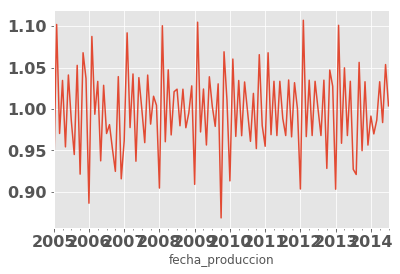

In [92]:
df_train.groupby('fecha_produccion').Produccion_barriles_t.median().plot()

# Clustering Vemos que hay tipos de pozos con produccion similar

In [93]:
df_train.head()

,Pozo,fecha_produccion,Produccion_barriles_t_12,Produccion_barriles_t_11,Produccion_barriles_t_10,Produccion_barriles_t_9,Produccion_barriles_t_8,Produccion_barriles_t_7,Produccion_barriles_t_6,Produccion_barriles_t_5,...,equipo_perforacion_PM-5571,equipo_perforacion_PM-5596,equipo_perforacion_PM-5597,equipo_perforacion_PM-5599,equipo_perforacion_PM-5626,equipo_perforacion_PM-5627,equipo_perforacion_PM-73,equipo_perforacion_PM-78,equipo_perforacion_PM-92,equipo_perforacion_SIN INFORMACION
0,MOLOACAN-111,2005-01-01,0.950135,1.056198,0.661237,0.702259,0.336793,9.306626,1.131854,1.005910,...,0,0,0,0,0,0,0,0,0,1
6,MOLOACAN-111,2008-03-01,0.978052,1.094987,0.600447,0.822515,0.354761,1.364668,2.070753,0.966936,...,0,0,0,0,0,0,0,0,0,1
7,MOLOACAN-111,2008-04-01,1.094987,0.600447,0.822515,0.354761,1.364668,2.070753,0.966936,1.034247,...,0,0,0,0,0,0,0,0,0,1
8,MOLOACAN-111,2008-05-01,0.600447,0.822515,0.354761,1.364668,2.070753,0.966936,1.034247,0.950181,...,0,0,0,0,0,0,0,0,0,1
9,MOLOACAN-111,2008-06-01,0.822515,0.354761,1.364668,2.070753,0.966936,1.034247,0.950181,1.031839,...,0,0,0,0,0,0,0,0,0,1


In [94]:
np.array(df_train.columns)

array(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_12',
       'Produccion_barriles_t_11', 'Produccion_barriles_t_10',
       'Produccion_barriles_t_9', 'Produccion_barriles_t_8',
       'Produccion_barriles_t_7', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t',
       'y_real_oil_t_1', 'y_real_oil', 'f_prod', 'diff_t_12_t_11',
       'diff_t_11_t_10', 'diff_t_10_t_9', 'diff_t_9_t_8', 'diff_t_8_t_7',
       'diff_t_7_t_6', 'diff_t_6_t_5', 'diff_t_5_t_4', 'diff_t_4_t_3',
       'diff_t_3_t_2', 'diff_t_6_t_1', 'diff_t_5_t_1', 'diff_t_4_t_1',
       'diff_t_3_t_1', 'diff_t_2_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'ratio_t_12_t_11',
       'ratio_t_11_t_10', 'ratio_t_10_t_9', 'ratio_t_9_t_8',
       'ratio_t_8_t_7', 'ratio_t_7_t_6', 'ratio_t_6_t_5', 'ratio_t_5_t_4',


In [96]:
num_cols = [i for i in df_train.columns if i not in ['Pozo',
            'fecha_produccion','Produccion_barriles_t','Produccion_gasMMpc_t',
            'dummi_pico_bajo','equipo_perforacion_PM-78', 'y_real_oil_t_1', 'y_real_oil', 'f_prod',
             'latitud', 'longitud','y_real_gas_t_1','y_real_gas','primera_fecha_produccion']]
num_cols

['Produccion_barriles_t_12',
 'Produccion_barriles_t_11',
 'Produccion_barriles_t_10',
 'Produccion_barriles_t_9',
 'Produccion_barriles_t_8',
 'Produccion_barriles_t_7',
 'Produccion_barriles_t_6',
 'Produccion_barriles_t_5',
 'Produccion_barriles_t_4',
 'Produccion_barriles_t_3',
 'Produccion_barriles_t_2',
 'Produccion_barriles_t_1',
 'diff_t_12_t_11',
 'diff_t_11_t_10',
 'diff_t_10_t_9',
 'diff_t_9_t_8',
 'diff_t_8_t_7',
 'diff_t_7_t_6',
 'diff_t_6_t_5',
 'diff_t_5_t_4',
 'diff_t_4_t_3',
 'diff_t_3_t_2',
 'diff_t_6_t_1',
 'diff_t_5_t_1',
 'diff_t_4_t_1',
 'diff_t_3_t_1',
 'diff_t_2_t_1',
 'aceleracion_de_produccion _t3t2_t2t1',
 'aceleracion_de_produccion _t4t3_t2t1',
 'ratio_t_12_t_11',
 'ratio_t_11_t_10',
 'ratio_t_10_t_9',
 'ratio_t_9_t_8',
 'ratio_t_8_t_7',
 'ratio_t_7_t_6',
 'ratio_t_6_t_5',
 'ratio_t_5_t_4',
 'ratio_t_4_t_3',
 'ratio_t_3_t_2',
 'ratio_t_6_t_1',
 'ratio_t_5_t_1',
 'ratio_t_4_t_1',
 'ratio_t_3_t_1',
 'ratio_t_2_t_1',
 'subio_t_12_t_11',
 'subio_t_11_t_10',
 'subio_t_10_t_9',
 'subio_t_9_t_8',
 'subio_t_8_t_7',
 'subio_t_7_t_6',
 'subio_t_6_t_5',
 'subio_t_5_t_4',
 'subio_t_4_t_3',
 'subio_t_3_t_2',
 'subio_t_2_t_1',
 'num_subidas',
 'bajo_t_12_t_11',
 'bajo_t_11_t_10',
 'bajo_t_10_t_9',
 'bajo_t_9_t_8',
 'bajo_t_8_t_7',
 'bajo_t_7_t_6',
 'bajo_t_6_t_5',
 'bajo_t_5_t_4',
 'bajo_t_4_t_3',
 'bajo_t_3_t_2',
 'bajo_t_2_t_1',
 'num_bajadas',
 'std_t_12_t_1',
 'median_t_12_t_1',
 'min_t_12_t_1',
 'q75_t_12_t_1',
 'q25_t_12_t_1',
 'q90_t_12_t_1',
 'q10_t_12_t_1',
 'max_t_12_t_1',
 'rango_t12_t1',
 'media_movil_t_2_t_1',
 'media_movil_t_3_t_1',
 'media_movil_t_4_t_1',
 'media_movil_t_5_t_1',
 'media_movil_t_6_t_1',
 'media_movil_t_12_t_1',
 'produccion_anual',
 'Tasa_Declinacion_anual',
 'Tasa_Declinacion_Efectiva',
 'Produccion_gasMMpc_t_12',
 'Produccion_gasMMpc_t_11',
 'Produccion_gasMMpc_t_10',
 'Produccion_gasMMpc_t_9',
 'Produccion_gasMMpc_t_8',
 'Produccion_gasMMpc_t_7',
 'Produccion_gasMMpc_t_6',
 'Produccion_gasMMpc_t_5',
 'Produccion_gasMMpc_t_4',
 'Produccion_gasMMpc_t_3',
 'Produccion_gasMMpc_t_2',
 'Produccion_gasMMpc_t_1',
 'stdgas_t_12_t_1',
 'mediangas_t_12_t_1',
 'mingas_t_12_t_1',
 'q75gas_t_12_t_1',
 'q25gas_t_12_t_1',
 'q90gas_t_12_t_1',
 'q10gas_t_12_t_1',
 'maxgas_t_12_t_1',
 'rangogas_t12_t1',
 'media_movilgas_t_2_t_1',
 'media_movilgas_t_3_t_1',
 'media_movilgas_t_4_t_1',
 'media_movilgas_t_5_t_1',
 'media_movilgas_t_6_t_1',
 'media_movilgas_t_12_t_1',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'equipo_perforacion_PM-113',
 'equipo_perforacion_PM-472',
 'equipo_perforacion_PM-504',
 'equipo_perforacion_PM-5571',
 'equipo_perforacion_PM-5596',
 'equipo_perforacion_PM-5597',
 'equipo_perforacion_PM-5599',
 'equipo_perforacion_PM-5626',
 'equipo_perforacion_PM-5627',
 'equipo_perforacion_PM-73',
 'equipo_perforacion_PM-92',
 'equipo_perforacion_SIN INFORMACION']

In [97]:
df_std = (df_train[num_cols] - df_train[num_cols].mean()) / df_train[num_cols].std()

In [98]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, n_jobs=6)
    km = km.fit(df_std)
    Sum_of_squared_distances.append(km.inertia_)

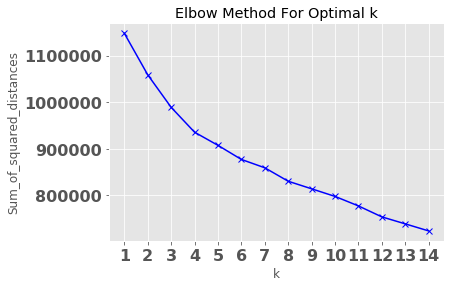

In [99]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.xticks(np.arange(1,15));

In [100]:
kmeans = KMeans(n_clusters=7, n_jobs=6)
kmeans.fit(df_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=6, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [101]:
df_train = pd.concat([df_train, pd.get_dummies(kmeans.predict(df_std),prefix="cluster")],1).dropna()

In [102]:
 len(kmeans.predict(df_std))

8380

In [103]:
len(df_train)

7691

In [104]:
df_train["cluster"] = pd.DataFrame(kmeans.predict(df_std)).dropna()

Si ayuda agregar clusters, vemos que hay pozos que producen menos.

# Caracteristicas del pozo

In [105]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_12',
       'Produccion_barriles_t_11', 'Produccion_barriles_t_10',
       'Produccion_barriles_t_9', 'Produccion_barriles_t_8',
       'Produccion_barriles_t_7', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5',
       ...
       'equipo_perforacion_PM-92', 'equipo_perforacion_SIN INFORMACION',
       'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4',
       'cluster_5', 'cluster_6', 'cluster'],
      dtype='object', length=158)

# AED

Text(0.5, 1.0, 'Histograma de variable predictiva')

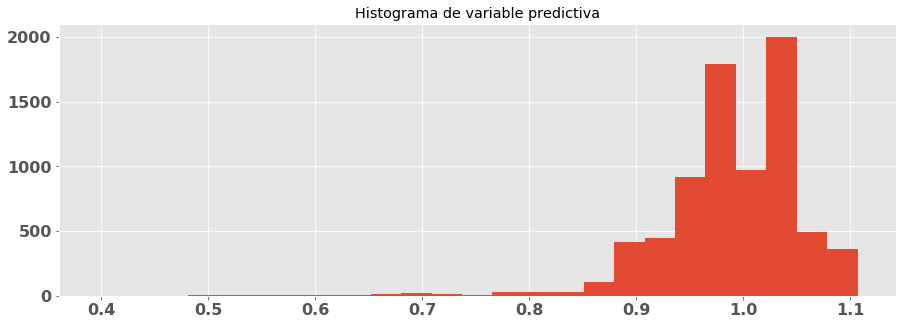

In [106]:
df_train.Produccion_barriles_t.hist(bins=25, figsize=(15,5))
plt.title('Histograma de variable predictiva')
# plt.xticks(np.linspace(0,4000,15));

# Dispersiones

En algun momento dibujaras un mapa aqui

In [107]:
num_cols

['Produccion_barriles_t_12',
 'Produccion_barriles_t_11',
 'Produccion_barriles_t_10',
 'Produccion_barriles_t_9',
 'Produccion_barriles_t_8',
 'Produccion_barriles_t_7',
 'Produccion_barriles_t_6',
 'Produccion_barriles_t_5',
 'Produccion_barriles_t_4',
 'Produccion_barriles_t_3',
 'Produccion_barriles_t_2',
 'Produccion_barriles_t_1',
 'diff_t_12_t_11',
 'diff_t_11_t_10',
 'diff_t_10_t_9',
 'diff_t_9_t_8',
 'diff_t_8_t_7',
 'diff_t_7_t_6',
 'diff_t_6_t_5',
 'diff_t_5_t_4',
 'diff_t_4_t_3',
 'diff_t_3_t_2',
 'diff_t_6_t_1',
 'diff_t_5_t_1',
 'diff_t_4_t_1',
 'diff_t_3_t_1',
 'diff_t_2_t_1',
 'aceleracion_de_produccion _t3t2_t2t1',
 'aceleracion_de_produccion _t4t3_t2t1',
 'ratio_t_12_t_11',
 'ratio_t_11_t_10',
 'ratio_t_10_t_9',
 'ratio_t_9_t_8',
 'ratio_t_8_t_7',
 'ratio_t_7_t_6',
 'ratio_t_6_t_5',
 'ratio_t_5_t_4',
 'ratio_t_4_t_3',
 'ratio_t_3_t_2',
 'ratio_t_6_t_1',
 'ratio_t_5_t_1',
 'ratio_t_4_t_1',
 'ratio_t_3_t_1',
 'ratio_t_2_t_1',
 'subio_t_12_t_11',
 'subio_t_11_t_10',
 'subio_t_10_t_9',
 'subio_t_9_t_8',
 'subio_t_8_t_7',
 'subio_t_7_t_6',
 'subio_t_6_t_5',
 'subio_t_5_t_4',
 'subio_t_4_t_3',
 'subio_t_3_t_2',
 'subio_t_2_t_1',
 'num_subidas',
 'bajo_t_12_t_11',
 'bajo_t_11_t_10',
 'bajo_t_10_t_9',
 'bajo_t_9_t_8',
 'bajo_t_8_t_7',
 'bajo_t_7_t_6',
 'bajo_t_6_t_5',
 'bajo_t_5_t_4',
 'bajo_t_4_t_3',
 'bajo_t_3_t_2',
 'bajo_t_2_t_1',
 'num_bajadas',
 'std_t_12_t_1',
 'median_t_12_t_1',
 'min_t_12_t_1',
 'q75_t_12_t_1',
 'q25_t_12_t_1',
 'q90_t_12_t_1',
 'q10_t_12_t_1',
 'max_t_12_t_1',
 'rango_t12_t1',
 'media_movil_t_2_t_1',
 'media_movil_t_3_t_1',
 'media_movil_t_4_t_1',
 'media_movil_t_5_t_1',
 'media_movil_t_6_t_1',
 'media_movil_t_12_t_1',
 'produccion_anual',
 'Tasa_Declinacion_anual',
 'Tasa_Declinacion_Efectiva',
 'Produccion_gasMMpc_t_12',
 'Produccion_gasMMpc_t_11',
 'Produccion_gasMMpc_t_10',
 'Produccion_gasMMpc_t_9',
 'Produccion_gasMMpc_t_8',
 'Produccion_gasMMpc_t_7',
 'Produccion_gasMMpc_t_6',
 'Produccion_gasMMpc_t_5',
 'Produccion_gasMMpc_t_4',
 'Produccion_gasMMpc_t_3',
 'Produccion_gasMMpc_t_2',
 'Produccion_gasMMpc_t_1',
 'stdgas_t_12_t_1',
 'mediangas_t_12_t_1',
 'mingas_t_12_t_1',
 'q75gas_t_12_t_1',
 'q25gas_t_12_t_1',
 'q90gas_t_12_t_1',
 'q10gas_t_12_t_1',
 'maxgas_t_12_t_1',
 'rangogas_t12_t1',
 'media_movilgas_t_2_t_1',
 'media_movilgas_t_3_t_1',
 'media_movilgas_t_4_t_1',
 'media_movilgas_t_5_t_1',
 'media_movilgas_t_6_t_1',
 'media_movilgas_t_12_t_1',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'equipo_perforacion_PM-113',
 'equipo_perforacion_PM-472',
 'equipo_perforacion_PM-504',
 'equipo_perforacion_PM-5571',
 'equipo_perforacion_PM-5596',
 'equipo_perforacion_PM-5597',
 'equipo_perforacion_PM-5599',
 'equipo_perforacion_PM-5626',
 'equipo_perforacion_PM-5627',
 'equipo_perforacion_PM-73',
 'equipo_perforacion_PM-92',
 'equipo_perforacion_SIN INFORMACION']

In [108]:
# for i in num_cols:
#     plt.subplots()
#     sns.regplot(df_train[i],df_train.Produccion_barriles_t,)
#     plt.title(i)

In [109]:
# lat = df_train.groupby('Pozo')[['latitud','longitud']].first().latitud.values
# lon = df_train.groupby('Pozo')[['latitud','longitud']].first().latitud.values
# idx = df_train.groupby('Pozo')[['latitud','longitud']].first().index.values

In [110]:
df_prod_heatmap = df_train.set_index('fecha_produccion').groupby([
    'Pozo',pd.Grouper(freq='1Y')]).Produccion_barriles_t.sum()

Text(0.5, 1.0, 'Produccion anual por pozo, historia')

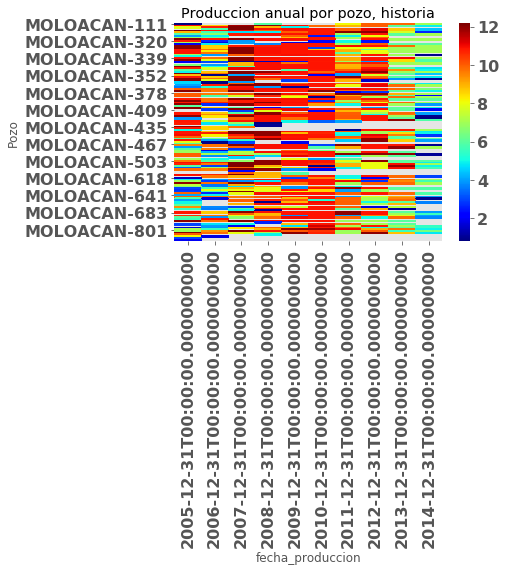

In [111]:
sns.heatmap(df_prod_heatmap.unstack(),cmap='jet')
plt.title('Produccion anual por pozo, historia')

In [112]:
df_prod_heatmap = df_prod_heatmap.reset_index()

In [113]:
# df_prod_heatmap[df_prod_heatmap.fecha_produccion == '1999-12-31'].merge(
#     lat_lon_pozo[['Pozo','latitud','longitud']], on='Pozo').set_index('Pozo').Produccion_barriles_t.sort_values().plot.barh()

# heatmap por produccion Pendiente

Text(0.5, 1.0, 'Observamos que hay pozos estables en cantidad de produccion y\n            otros que ascienden o descienden en produccion')

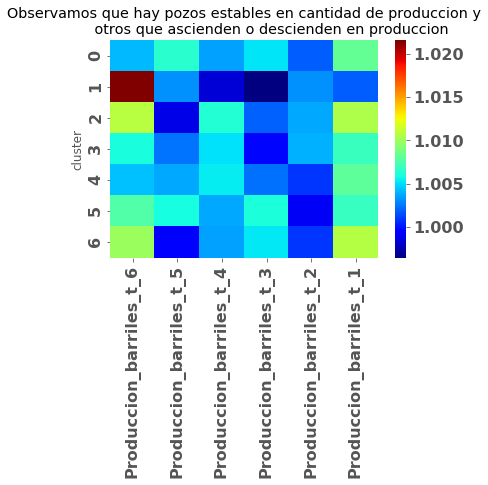

In [114]:
sns.heatmap(df_train.groupby('cluster')[[ 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1']].mean(),cmap='jet')
plt.title('''Observamos que hay pozos estables en cantidad de produccion y
            otros que ascienden o descienden en produccion''')

# Entrenamiento

In [115]:
df_train.reset_index(inplace=True,drop=True)

In [116]:
num_cols = [i for i in df_train.columns if i not in ['Pozo',
            'fecha_produccion','Produccion_barriles_t','Produccion_gasMMpc_t',
            'dummi_pico_bajo','equipo_perforacion_PM-78','cluster','y_real_oil_t_1', 
            'y_real_oil', 'f_prod', 'latitud', 'longitud','y_real_gas_t_1', 'y_real_gas', 'primera_fecha_produccion']]
num_cols

['Produccion_barriles_t_12',
 'Produccion_barriles_t_11',
 'Produccion_barriles_t_10',
 'Produccion_barriles_t_9',
 'Produccion_barriles_t_8',
 'Produccion_barriles_t_7',
 'Produccion_barriles_t_6',
 'Produccion_barriles_t_5',
 'Produccion_barriles_t_4',
 'Produccion_barriles_t_3',
 'Produccion_barriles_t_2',
 'Produccion_barriles_t_1',
 'diff_t_12_t_11',
 'diff_t_11_t_10',
 'diff_t_10_t_9',
 'diff_t_9_t_8',
 'diff_t_8_t_7',
 'diff_t_7_t_6',
 'diff_t_6_t_5',
 'diff_t_5_t_4',
 'diff_t_4_t_3',
 'diff_t_3_t_2',
 'diff_t_6_t_1',
 'diff_t_5_t_1',
 'diff_t_4_t_1',
 'diff_t_3_t_1',
 'diff_t_2_t_1',
 'aceleracion_de_produccion _t3t2_t2t1',
 'aceleracion_de_produccion _t4t3_t2t1',
 'ratio_t_12_t_11',
 'ratio_t_11_t_10',
 'ratio_t_10_t_9',
 'ratio_t_9_t_8',
 'ratio_t_8_t_7',
 'ratio_t_7_t_6',
 'ratio_t_6_t_5',
 'ratio_t_5_t_4',
 'ratio_t_4_t_3',
 'ratio_t_3_t_2',
 'ratio_t_6_t_1',
 'ratio_t_5_t_1',
 'ratio_t_4_t_1',
 'ratio_t_3_t_1',
 'ratio_t_2_t_1',
 'subio_t_12_t_11',
 'subio_t_11_t_10',
 'subio_t_10_t_9',
 'subio_t_9_t_8',
 'subio_t_8_t_7',
 'subio_t_7_t_6',
 'subio_t_6_t_5',
 'subio_t_5_t_4',
 'subio_t_4_t_3',
 'subio_t_3_t_2',
 'subio_t_2_t_1',
 'num_subidas',
 'bajo_t_12_t_11',
 'bajo_t_11_t_10',
 'bajo_t_10_t_9',
 'bajo_t_9_t_8',
 'bajo_t_8_t_7',
 'bajo_t_7_t_6',
 'bajo_t_6_t_5',
 'bajo_t_5_t_4',
 'bajo_t_4_t_3',
 'bajo_t_3_t_2',
 'bajo_t_2_t_1',
 'num_bajadas',
 'std_t_12_t_1',
 'median_t_12_t_1',
 'min_t_12_t_1',
 'q75_t_12_t_1',
 'q25_t_12_t_1',
 'q90_t_12_t_1',
 'q10_t_12_t_1',
 'max_t_12_t_1',
 'rango_t12_t1',
 'media_movil_t_2_t_1',
 'media_movil_t_3_t_1',
 'media_movil_t_4_t_1',
 'media_movil_t_5_t_1',
 'media_movil_t_6_t_1',
 'media_movil_t_12_t_1',
 'produccion_anual',
 'Tasa_Declinacion_anual',
 'Tasa_Declinacion_Efectiva',
 'Produccion_gasMMpc_t_12',
 'Produccion_gasMMpc_t_11',
 'Produccion_gasMMpc_t_10',
 'Produccion_gasMMpc_t_9',
 'Produccion_gasMMpc_t_8',
 'Produccion_gasMMpc_t_7',
 'Produccion_gasMMpc_t_6',
 'Produccion_gasMMpc_t_5',
 'Produccion_gasMMpc_t_4',
 'Produccion_gasMMpc_t_3',
 'Produccion_gasMMpc_t_2',
 'Produccion_gasMMpc_t_1',
 'stdgas_t_12_t_1',
 'mediangas_t_12_t_1',
 'mingas_t_12_t_1',
 'q75gas_t_12_t_1',
 'q25gas_t_12_t_1',
 'q90gas_t_12_t_1',
 'q10gas_t_12_t_1',
 'maxgas_t_12_t_1',
 'rangogas_t12_t1',
 'media_movilgas_t_2_t_1',
 'media_movilgas_t_3_t_1',
 'media_movilgas_t_4_t_1',
 'media_movilgas_t_5_t_1',
 'media_movilgas_t_6_t_1',
 'media_movilgas_t_12_t_1',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'equipo_perforacion_PM-113',
 'equipo_perforacion_PM-472',
 'equipo_perforacion_PM-504',
 'equipo_perforacion_PM-5571',
 'equipo_perforacion_PM-5596',
 'equipo_perforacion_PM-5597',
 'equipo_perforacion_PM-5599',
 'equipo_perforacion_PM-5626',
 'equipo_perforacion_PM-5627',
 'equipo_perforacion_PM-73',
 'equipo_perforacion_PM-92',
 'equipo_perforacion_SIN INFORMACION',
 'cluster_0',
 'cluster_1',
 'cluster_2',
 'cluster_3',
 'cluster_4',
 'cluster_5',
 'cluster_6']

In [117]:
from sklearn.model_selection import train_test_split

In [118]:
def train_test_valid_split(df, x_cols, y_col):
    
    x_train_test, x_valid, y_train_test, y_valid = train_test_split(
    df[x_cols],
    df[y_col],
    test_size=0.1,
    random_state=8)

    x_train, x_test, y_train, y_test = train_test_split(x_train_test, 
                                                    y_train_test,
                                                    test_size = 0.2,
                                                    random_state=10)
    
    return x_train, x_test, x_valid, y_train, y_test, y_valid

In [126]:
x_train, x_test, x_valid, y_train, y_test, y_valid = train_test_valid_split(df_train, 
                                                    num_cols, 'Produccion_barriles_t')

In [127]:
df_train.shape

(7691, 158)

In [128]:
x_train.shape

(5536, 144)

In [129]:
y_train.shape

(5536,)

In [123]:
def split_train_test_valid(df, x_cols, y_cols, ratio_train = 0.8, ratio_test = 0.1):
    df_x = df[x_cols]
    df_y = df[y_cols]
    # split train, test and valid
    limite_train = round (df.shape[0] * ratio_train)
    limite_test = round (df.shape[0] * ratio_test)
    # set x
    x_train = df_x.iloc[:limite_train, :]
    x_test = df_x.iloc[limite_train:(limite_train + limite_test), :]
    x_valid = df_x.iloc[(limite_train + limite_test):, :]
    # set y
    y_train = df_y.iloc[:limite_train]
    y_test = df_y.iloc[limite_train:(limite_train + limite_test)]
    y_valid = df_y.iloc[(limite_train + limite_test):]
    return x_train, x_test, x_valid, y_train, y_test, y_valid

In [124]:
# split train, test and valid
limite_train = round (df_train.shape[0] * 0.8)
limite_test = round (df_train.shape[0] * 0.1)
# set x
x_train = df_train[num_cols].iloc[:limite_train, :]
x_test = df_train[num_cols].iloc[limite_train:(limite_train + limite_test), :]
x_valid = df_train[num_cols].iloc[(limite_train + limite_test):, :]
# set y
y_train = df_train['Produccion_barriles_t'].iloc[:limite_train]
y_test = df_train['Produccion_barriles_t'].iloc[limite_train:(limite_train + limite_test)]
y_valid = df_train['Produccion_barriles_t'].iloc[(limite_train + limite_test):]

In [130]:
x_train.shape[0] + x_test.shape[0] + x_valid.shape[0] == df_train.shape[0]

True

In [131]:
x_train.shape

(5536, 144)

In [132]:
y_train.shape

(5536,)

In [133]:
d_train = lgb.Dataset(x_train, y_train)
d_test = lgb.Dataset(x_test, label=y_test)

params = {}
params['learning_rate'] = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'
params['sub_feature'] = 0.5
params['num_leaves'] = 50
params['min_data'] = 1
params['max_depth'] = -1
params['num_iterations'] = 100000

clf = lgb.train(params, d_train, 1000, valid_sets=[d_test], early_stopping_rounds=25,verbose_eval=10000)

Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[2404]	valid_0's l1: 0.0173018


In [134]:
clf.num_trees()

2404

# Evaluacion

In [135]:
df_train.head()

,Pozo,fecha_produccion,Produccion_barriles_t_12,Produccion_barriles_t_11,Produccion_barriles_t_10,Produccion_barriles_t_9,Produccion_barriles_t_8,Produccion_barriles_t_7,Produccion_barriles_t_6,Produccion_barriles_t_5,...,equipo_perforacion_PM-92,equipo_perforacion_SIN INFORMACION,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster
0,MOLOACAN-111,2005-01-01,0.950135,1.056198,0.661237,0.702259,0.336793,9.306626,1.131854,1.005910,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
1,MOLOACAN-111,2008-03-01,0.978052,1.094987,0.600447,0.822515,0.354761,1.364668,2.070753,0.966936,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6
2,MOLOACAN-111,2008-04-01,1.094987,0.600447,0.822515,0.354761,1.364668,2.070753,0.966936,1.034247,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5
3,MOLOACAN-111,2008-05-01,0.600447,0.822515,0.354761,1.364668,2.070753,0.966936,1.034247,0.950181,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2
4,MOLOACAN-111,2008-06-01,0.822515,0.354761,1.364668,2.070753,0.966936,1.034247,0.950181,1.031839,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [136]:
y_pred = df_train.iloc[x_valid.index].y_real_oil_t_1 * clf.predict(x_valid)
y_real = df_train.iloc[x_valid.index].y_real_oil_t_1 * y_valid

In [137]:
def report_evaluation_regression(y_real, y_pred, num_features):
    """Reporte de evaluacion,
    y_real, y_pred=y_estimada,num_features=numero de variables"""
    R2=metrics.r2_score(y_real,y_pred)
    n=len(y_real)
    p=num_features
    r2 = 1-(1-R2)*(n-1)/(n-p-1)
    
    
    print("R^2: %1.4f" % R2)
    
    print("R^2 ajustada$: %1.4f" % r2)
    
    print("MEA: %1.4f" % metrics.mean_absolute_error(y_real,y_pred))
    print("MSE %1.4f" % metrics.mean_squared_error(y_real,y_pred))
    print("RMSE %1.4f" % np.sqrt(metrics.mean_squared_error(y_real,y_pred)))

In [138]:
report_evaluation_regression(y_real, y_pred, x_train.shape[1])

R^2: 0.9852
R^2 ajustada$: 0.9818
MEA: 6.1718
MSE 376.5621
RMSE 19.4052


In [139]:
def yy_plot(y_real, y_pred):
    plt.scatter(y_real, y_pred, alpha=0.5)
    mi2,ma2 = y_real.min(), y_real.max()
    mi1,ma1 = y_pred.min(), y_pred.max()
    plt.plot([mi2,ma2],[mi1,ma1], linestyle='--', color='navy')
    plt.xlabel('Y_real')
    plt.ylabel('Y_estimada')

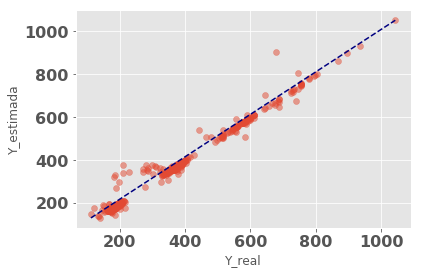

In [140]:
yy_plot(y_real, y_pred)

## Residuos

In [141]:
res = (y_real - y_pred) / y_real

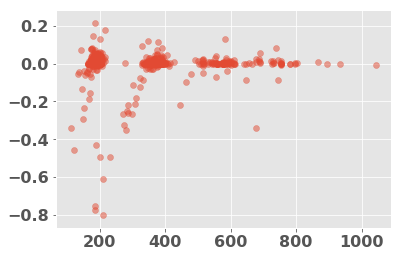

In [142]:
plt.scatter(y_real, res, alpha=0.5)

In [143]:
res.median() * 100

0.1053929171906431

In [144]:
res.mean() * 100

-0.5479029364972114

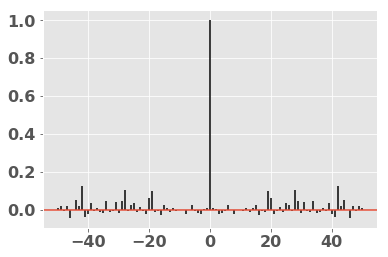

In [145]:
plt.xcorr(res, res,maxlags=50, usevlines=1)
plt.show()

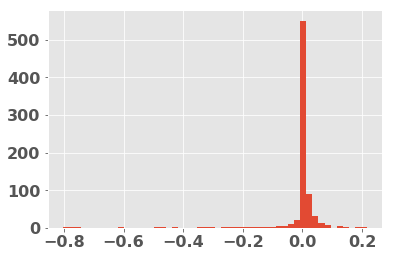

In [146]:
res.hist(bins=50)

## Autocorrelacion

Blogs indican que es mejor hacer la estimacion de $\hat{y}=P(t)-P(t-1)=\alpha + \sum {\beta X_i} + \epsilon$

Se generan mas variables para ayudarle al modelo

# Interpretacion

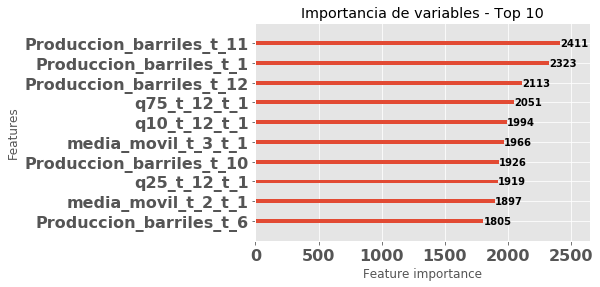

In [147]:
lgb.plot_importance(clf,max_num_features=10, title='Importancia de variables - Top 10')

In [148]:
def shap_shap(clf, x_valid):
    explainer = shap.TreeExplainer(clf)
    return explainer, explainer.shap_values(x_valid)

In [149]:
explainer, shap_values = shap_shap(clf, x_valid)

In [150]:
shap.force_plot(explainer.expected_value, shap_values[5,:], x_valid.iloc[5,:])

## Efectos Marginales

In [151]:
a = pd.DataFrame(clf.feature_importance(), index=x_valid.columns,
             columns=['imp']).sort_values('imp')

In [152]:
a.tail(8).index

Index(['q25_t_12_t_1', 'Produccion_barriles_t_10', 'media_movil_t_3_t_1',
       'q10_t_12_t_1', 'q75_t_12_t_1', 'Produccion_barriles_t_12',
       'Produccion_barriles_t_1', 'Produccion_barriles_t_11'],
      dtype='object')

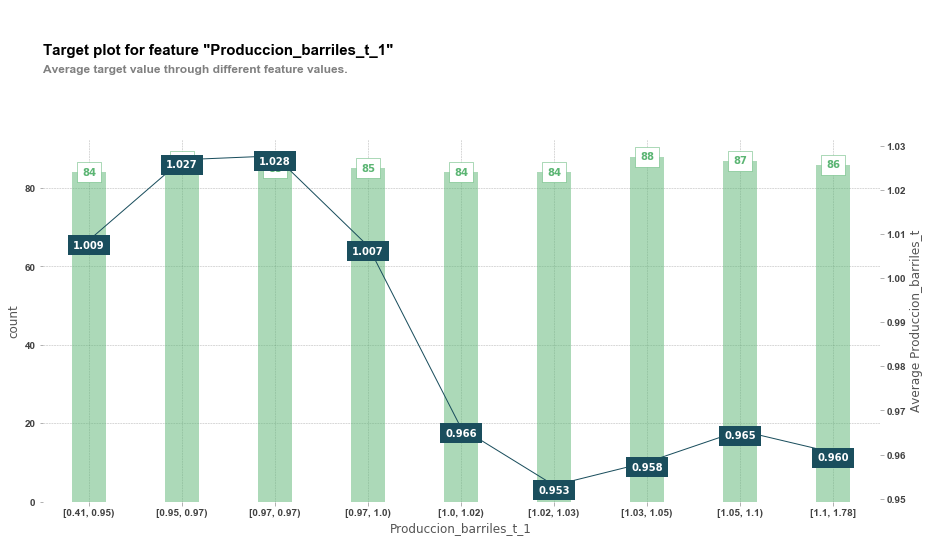

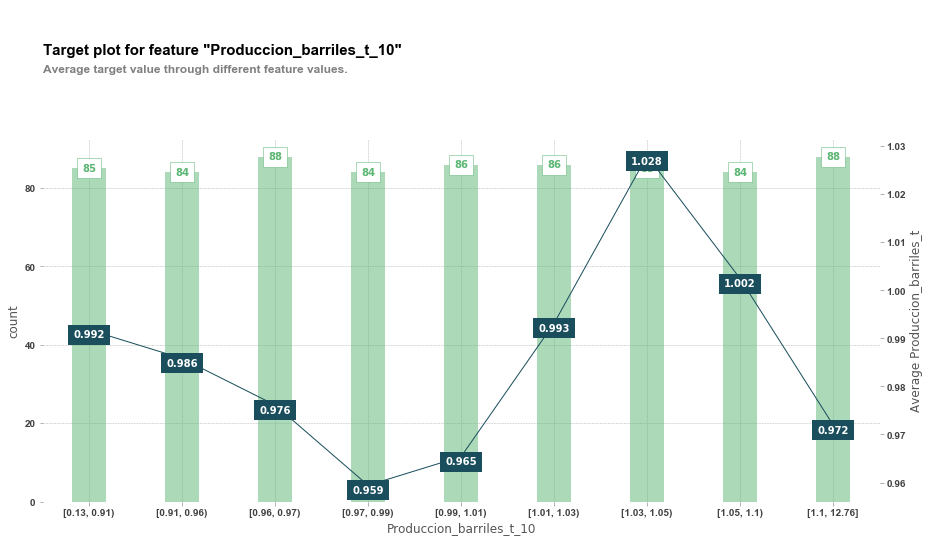

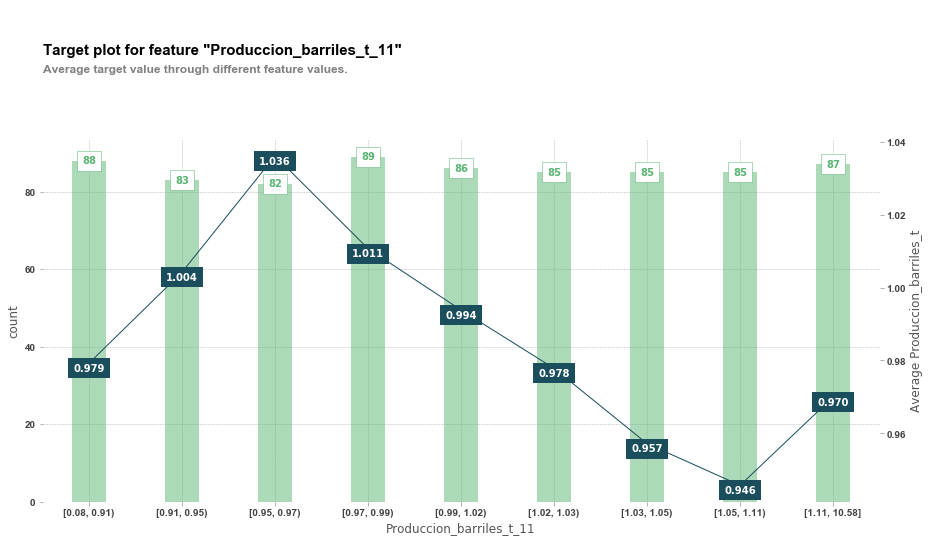

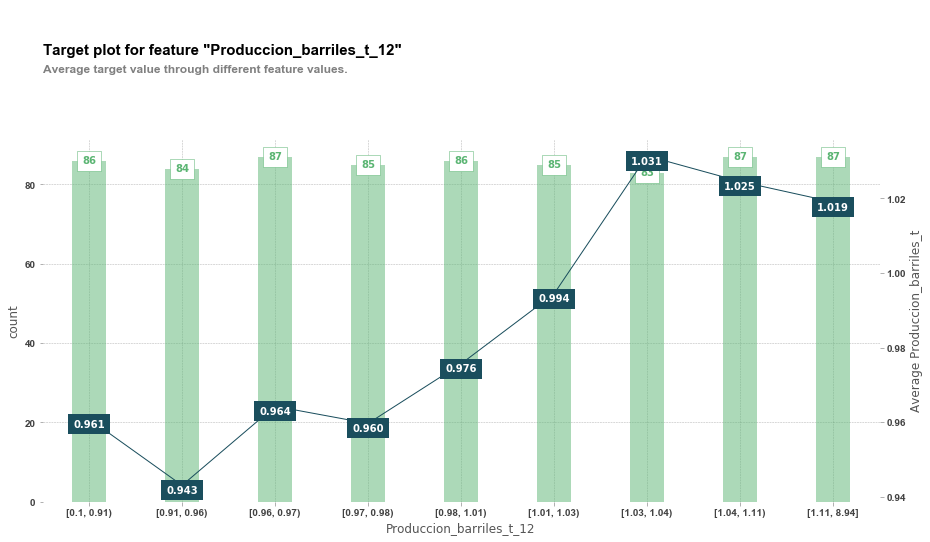

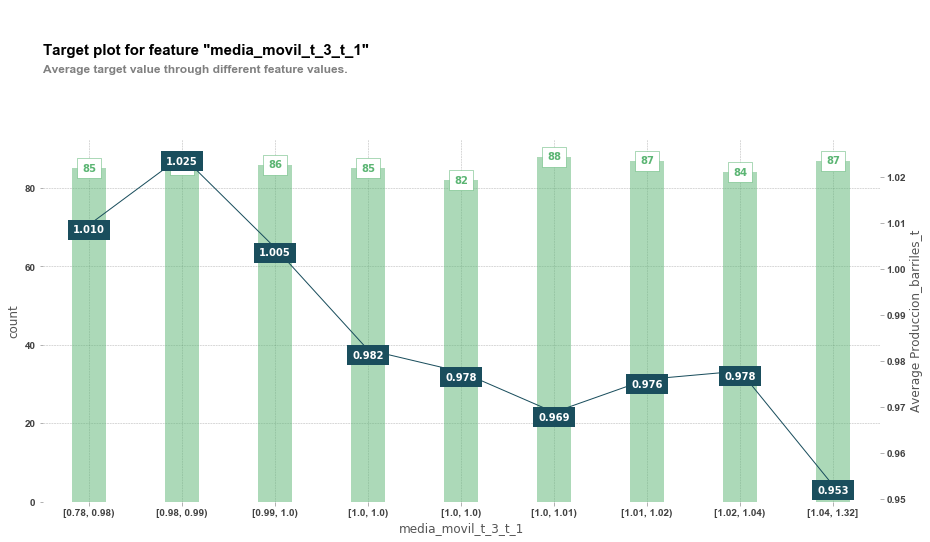

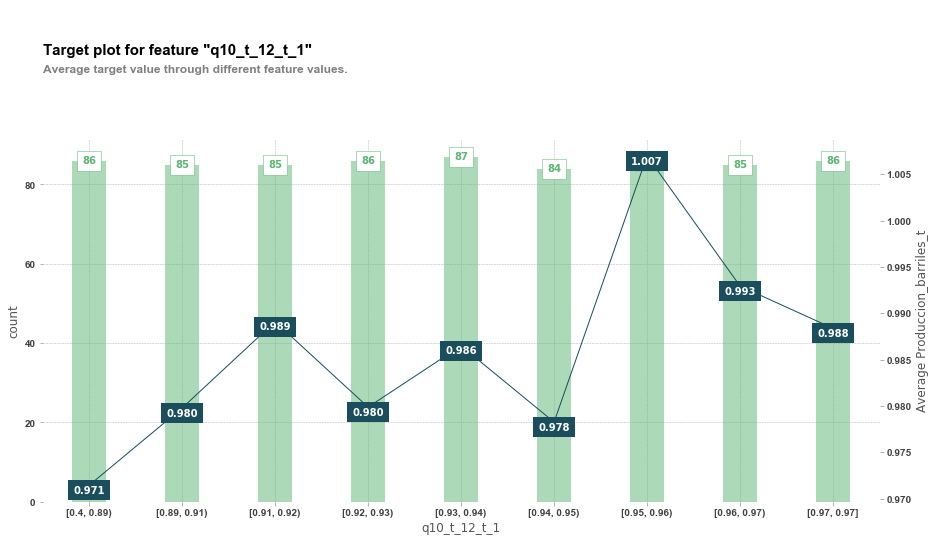

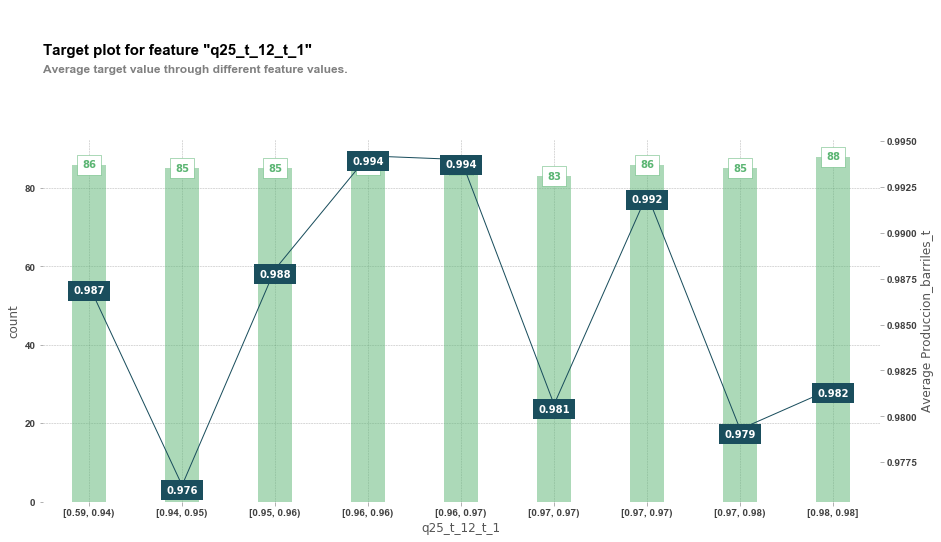

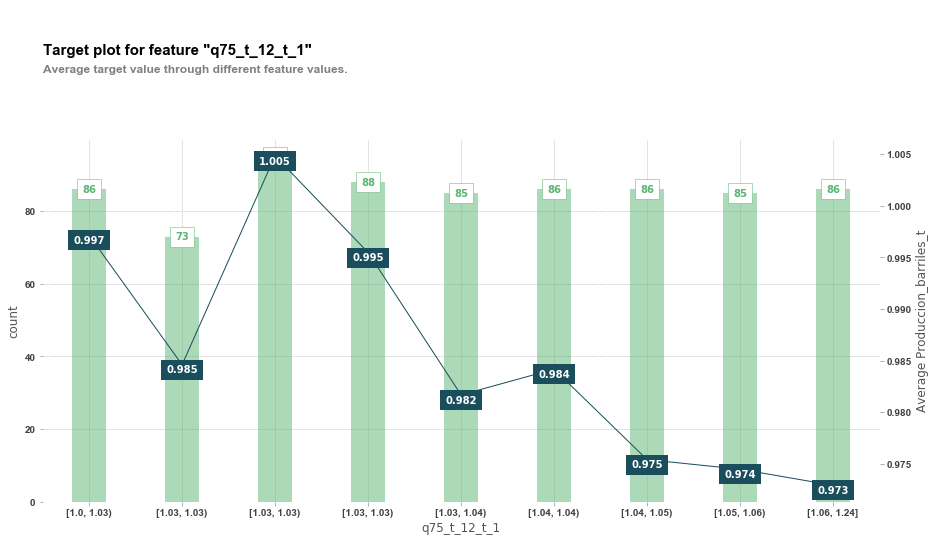

In [153]:
for col in sorted(a.tail(8).index):
    fig, axes, summary_df = info_plots.target_plot(
        df=pd.concat([x_valid,y_valid],1)
        , feature=col, 
        feature_name=col, 
        target='Produccion_barriles_t'
    )

## Pendiente interpretar los de shap

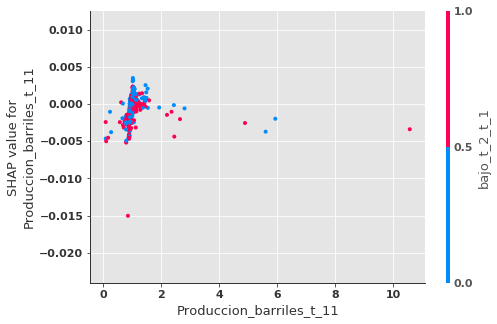

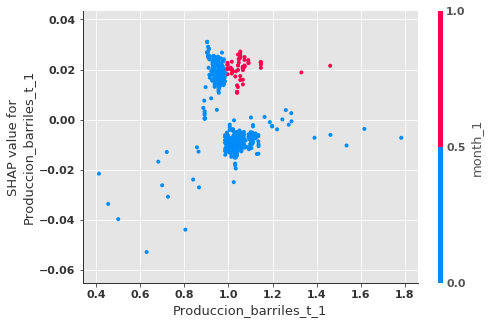

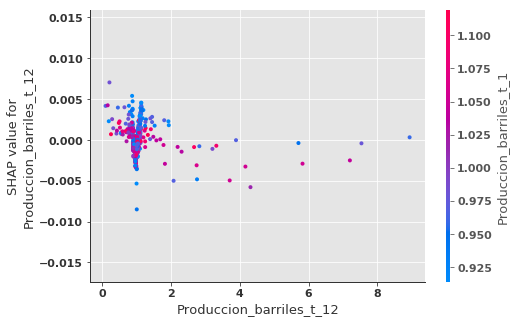

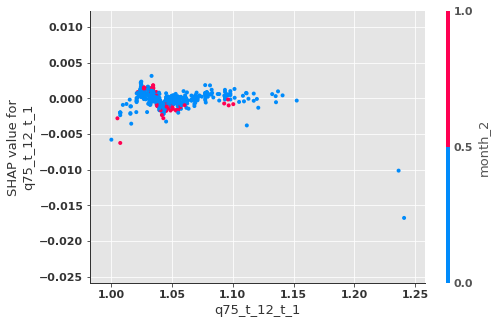

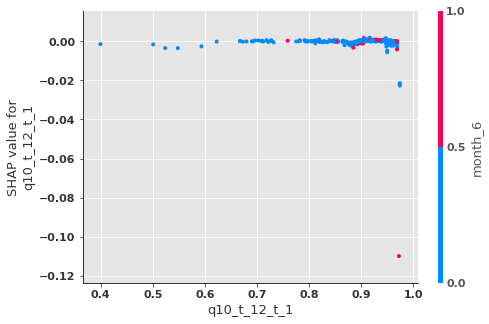

In [154]:
for col in a.sort_values('imp',ascending=False).head(5).index:
    shap.dependence_plot(col, shap_values, x_valid)

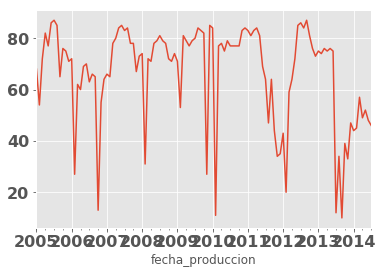

In [155]:
df_train.groupby('fecha_produccion').count()['Pozo'].plot()

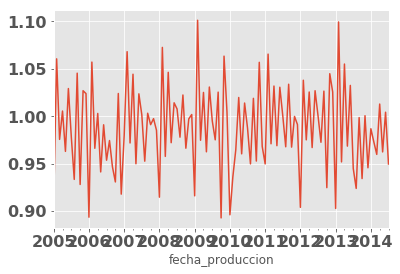

In [156]:
df_train.groupby('fecha_produccion')['Produccion_barriles_t'].mean().plot()

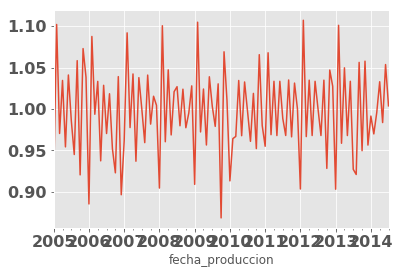

In [157]:
df_train.groupby('fecha_produccion')['Produccion_barriles_t'].median().plot()
# .sort_values(ascending=False)

# Guardado de mejor modelo

In [158]:
#joblib.dump(clf, 'light_gbm_oil_04-08-2019.pkl')

In [159]:
# carga de modelo
# gbm_pickle = joblib.load('modelos/light_gbm_31-07-2019.pkl')

# Check de pozos aleatorios

In [160]:
idx = df_train.Pozo.sample(10)

In [161]:
index = df_train[df_train.Pozo.isin(idx)].groupby(['Pozo','fecha_produccion']).Produccion_barriles_t.first().index

In [162]:
validacion = df_train[df_train.Pozo.isin(idx)].groupby(['Pozo','fecha_produccion']).Produccion_barriles_t.first().unstack(0)

In [163]:
prediction = clf.predict(df_train[df_train.Pozo.isin(idx)][num_cols])

In [164]:
prediccion_validacion = pd.DataFrame(prediction,columns=['prediction']).set_index(index).unstack(0)

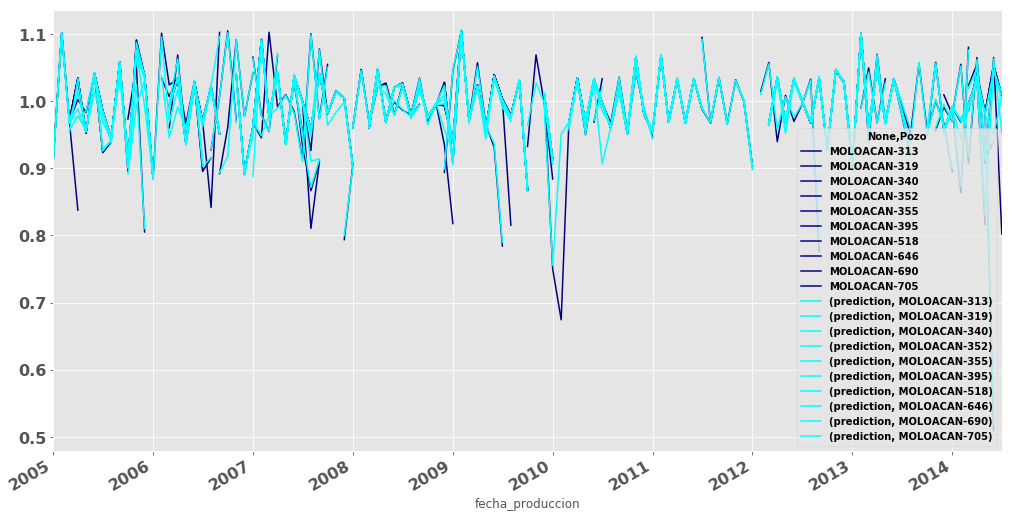

In [165]:
ax = validacion.plot(figsize=(17,9),color='navy')
prediccion_validacion.plot(ax = ax,color='cyan')

In [166]:
# pd.merge(validacion,prediccion_validacion,right_index=True, left_index=True).iplot()

# Pozo promedio

In [167]:
preds = df_train.y_real_oil_t_1 * clf.predict(df_train[num_cols])
real = df_train.y_real_oil

In [168]:
df_train['prediction_oil'] = preds

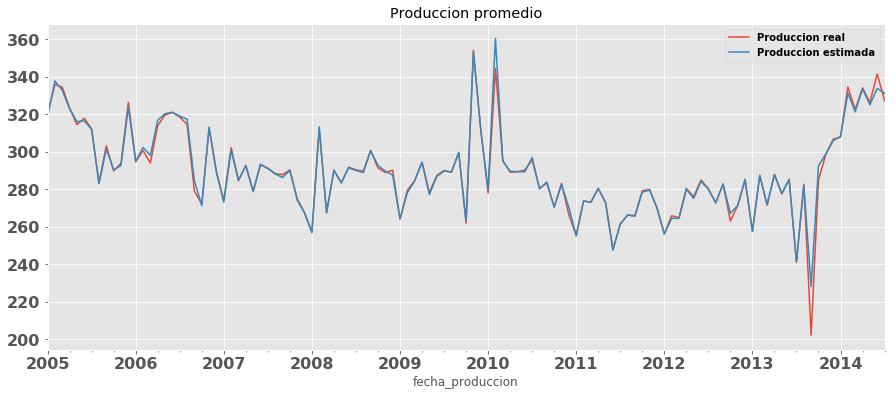

In [169]:
df_train.groupby('fecha_produccion')[['y_real_oil','prediction_oil']].mean().plot(
    figsize=(15,6), title='Produccion promedio')
plt.legend(['Produccion real', 'Produccion estimada'])

# Pozo Tipo Promedio Base 0
Seleccionar pozos que tengan al menos 10 anios de vida

En promedio tienen 110 mediciones, es decir, al menos 9 anios de vida

In [170]:
 df_train.groupby('Pozo').fecha_produccion.count().median()

70.0

In [171]:
pozos_vivos = df_train.groupby('Pozo').fecha_produccion.count()[
    df_train.groupby('Pozo').fecha_produccion.count() > 110].index

In [172]:
df_vivos = df_train[df_train.Pozo.isin(pozos_vivos)]

In [173]:
df_vivos = df_vivos[df_vivos.fecha_produccion > '2003-12-01']

In [174]:
a = df_vivos.groupby('Pozo').fecha_produccion.min()
idx_a = a[a=='2004-01-01'].index

In [175]:
df_vivos = df_vivos[df_vivos.Pozo.isin(idx_a)]

In [176]:
df_vivos2 = df_vivos.groupby('fecha_produccion')[['Produccion_barriles_t','prediction_oil']].mean()
df_vivos2["Qomes_b_t_q90"] = df_vivos.groupby('fecha_produccion')['Produccion_barriles_t'].quantile(0.90)
df_vivos2["Qomes_b_t_q10"] = df_vivos.groupby('fecha_produccion')['Produccion_barriles_t'].quantile(0.10)
df_vivos2["prediccion_q90"] = df_vivos.groupby('fecha_produccion')['prediction'].quantile(0.90)
df_vivos2["prediccion_q10"] = df_vivos.groupby('fecha_produccion')['prediction'].quantile(0.10)
df_vivos2['residuo'] = df_vivos2.Produccion_barriles_t - df_vivos2.prediction_oil

KeyError: 'Column not found: prediction'

In [ ]:
df_vivos2.iplot(title='Perfiles de pozos con su estimacion')

In [160]:
# df_vivos2.to_csv("perfiles_pozo.csv")

# Carga de modelos

In [184]:
from sklearn.externals import joblib

In [ ]:
# gbm_pickle = joblib.load('modelos/light_gbm_31-07-2019.pkl')

# Forecasting

In [177]:
num_cols

['Produccion_barriles_t_12',
 'Produccion_barriles_t_11',
 'Produccion_barriles_t_10',
 'Produccion_barriles_t_9',
 'Produccion_barriles_t_8',
 'Produccion_barriles_t_7',
 'Produccion_barriles_t_6',
 'Produccion_barriles_t_5',
 'Produccion_barriles_t_4',
 'Produccion_barriles_t_3',
 'Produccion_barriles_t_2',
 'Produccion_barriles_t_1',
 'diff_t_12_t_11',
 'diff_t_11_t_10',
 'diff_t_10_t_9',
 'diff_t_9_t_8',
 'diff_t_8_t_7',
 'diff_t_7_t_6',
 'diff_t_6_t_5',
 'diff_t_5_t_4',
 'diff_t_4_t_3',
 'diff_t_3_t_2',
 'diff_t_6_t_1',
 'diff_t_5_t_1',
 'diff_t_4_t_1',
 'diff_t_3_t_1',
 'diff_t_2_t_1',
 'aceleracion_de_produccion _t3t2_t2t1',
 'aceleracion_de_produccion _t4t3_t2t1',
 'ratio_t_12_t_11',
 'ratio_t_11_t_10',
 'ratio_t_10_t_9',
 'ratio_t_9_t_8',
 'ratio_t_8_t_7',
 'ratio_t_7_t_6',
 'ratio_t_6_t_5',
 'ratio_t_5_t_4',
 'ratio_t_4_t_3',
 'ratio_t_3_t_2',
 'ratio_t_6_t_1',
 'ratio_t_5_t_1',
 'ratio_t_4_t_1',
 'ratio_t_3_t_1',
 'ratio_t_2_t_1',
 'subio_t_12_t_11',
 'subio_t_11_t_10',
 'subio_t_10_t_9',
 'subio_t_9_t_8',
 'subio_t_8_t_7',
 'subio_t_7_t_6',
 'subio_t_6_t_5',
 'subio_t_5_t_4',
 'subio_t_4_t_3',
 'subio_t_3_t_2',
 'subio_t_2_t_1',
 'num_subidas',
 'bajo_t_12_t_11',
 'bajo_t_11_t_10',
 'bajo_t_10_t_9',
 'bajo_t_9_t_8',
 'bajo_t_8_t_7',
 'bajo_t_7_t_6',
 'bajo_t_6_t_5',
 'bajo_t_5_t_4',
 'bajo_t_4_t_3',
 'bajo_t_3_t_2',
 'bajo_t_2_t_1',
 'num_bajadas',
 'std_t_12_t_1',
 'median_t_12_t_1',
 'min_t_12_t_1',
 'q75_t_12_t_1',
 'q25_t_12_t_1',
 'q90_t_12_t_1',
 'q10_t_12_t_1',
 'max_t_12_t_1',
 'rango_t12_t1',
 'media_movil_t_2_t_1',
 'media_movil_t_3_t_1',
 'media_movil_t_4_t_1',
 'media_movil_t_5_t_1',
 'media_movil_t_6_t_1',
 'media_movil_t_12_t_1',
 'produccion_anual',
 'Tasa_Declinacion_anual',
 'Tasa_Declinacion_Efectiva',
 'Produccion_gasMMpc_t_12',
 'Produccion_gasMMpc_t_11',
 'Produccion_gasMMpc_t_10',
 'Produccion_gasMMpc_t_9',
 'Produccion_gasMMpc_t_8',
 'Produccion_gasMMpc_t_7',
 'Produccion_gasMMpc_t_6',
 'Produccion_gasMMpc_t_5',
 'Produccion_gasMMpc_t_4',
 'Produccion_gasMMpc_t_3',
 'Produccion_gasMMpc_t_2',
 'Produccion_gasMMpc_t_1',
 'stdgas_t_12_t_1',
 'mediangas_t_12_t_1',
 'mingas_t_12_t_1',
 'q75gas_t_12_t_1',
 'q25gas_t_12_t_1',
 'q90gas_t_12_t_1',
 'q10gas_t_12_t_1',
 'maxgas_t_12_t_1',
 'rangogas_t12_t1',
 'media_movilgas_t_2_t_1',
 'media_movilgas_t_3_t_1',
 'media_movilgas_t_4_t_1',
 'media_movilgas_t_5_t_1',
 'media_movilgas_t_6_t_1',
 'media_movilgas_t_12_t_1',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'equipo_perforacion_PM-113',
 'equipo_perforacion_PM-472',
 'equipo_perforacion_PM-504',
 'equipo_perforacion_PM-5571',
 'equipo_perforacion_PM-5596',
 'equipo_perforacion_PM-5597',
 'equipo_perforacion_PM-5599',
 'equipo_perforacion_PM-5626',
 'equipo_perforacion_PM-5627',
 'equipo_perforacion_PM-73',
 'equipo_perforacion_PM-92',
 'equipo_perforacion_SIN INFORMACION',
 'cluster_0',
 'cluster_1',
 'cluster_2',
 'cluster_3',
 'cluster_4',
 'cluster_5',
 'cluster_6']

In [178]:
for i,val in enumerate(df_train.columns):
    print(i,val)

0 Pozo
1 fecha_produccion
2 Produccion_barriles_t_12
3 Produccion_barriles_t_11
4 Produccion_barriles_t_10
5 Produccion_barriles_t_9
6 Produccion_barriles_t_8
7 Produccion_barriles_t_7
8 Produccion_barriles_t_6
9 Produccion_barriles_t_5
10 Produccion_barriles_t_4
11 Produccion_barriles_t_3
12 Produccion_barriles_t_2
13 Produccion_barriles_t_1
14 Produccion_barriles_t
15 y_real_oil_t_1
16 y_real_oil
17 f_prod
18 diff_t_12_t_11
19 diff_t_11_t_10
20 diff_t_10_t_9
21 diff_t_9_t_8
22 diff_t_8_t_7
23 diff_t_7_t_6
24 diff_t_6_t_5
25 diff_t_5_t_4
26 diff_t_4_t_3
27 diff_t_3_t_2
28 diff_t_6_t_1
29 diff_t_5_t_1
30 diff_t_4_t_1
31 diff_t_3_t_1
32 diff_t_2_t_1
33 aceleracion_de_produccion _t3t2_t2t1
34 aceleracion_de_produccion _t4t3_t2t1
35 ratio_t_12_t_11
36 ratio_t_11_t_10
37 ratio_t_10_t_9
38 ratio_t_9_t_8
39 ratio_t_8_t_7
40 ratio_t_7_t_6
41 ratio_t_6_t_5
42 ratio_t_5_t_4
43 ratio_t_4_t_3
44 ratio_t_3_t_2
45 ratio_t_6_t_1
46 ratio_t_5_t_1
47 ratio_t_4_t_1
48 ratio_t_3_t_1
49 ratio_t_2_t_1
50 

In [182]:
y_prueba_oil = clf.predict(df_train[num_cols][:1])
print(y_prueba_oil)

[0.8754092]


In [ ]:
y_prueba_gas = clf.predict(df_train[num_cols][:1])
print(y_prueba_gas)

In [490]:
def forecast_pozos(df_pozos, num_cols, algoritmo_oil, algoritmo_gas, inicio = 0, fin = 5, columna_inicial_oil = 2, columna_inicial_gas = 93, lag = 12):
    """Realiza forecasting para una lista de pozos.
    
    Parametros:
    df_pozos -- Lista de pozos para realizar forecasting
    num_cols -- Variables a utilizar en el algoritmo
    algoritmo - Algoritmo a utilizar (p.ej., clf)
    
    Return:
    df_pred -- DataFrame con las predicciones de cada pozo
    
    Variables:
    pozos -- Cantidad de pozos en la lsita
    
    Funciones auxiliares:
    gen_cols(df) -. Calcula las variables
    forecast(df, n_pred , num_cols, algoritmo, columna_inicial = 2, lag =7) - Realiza el forecast
    """
    if fin == 'all':
        fin = df_pozos.shape[0]
        
    # oil
    df_pozos['y(t-1)_oil'] = np.nan
    df_pozos['y(t)/y(t-1)_oil'] = np.nan
    df_pozos['y(t)_oil'] = np.nan
    #prediction
    df_pozos['predic_oil'] = np.nan
        
    # gas
    df_pozos['y(t-1)_gas'] = np.nan
    df_pozos['y(t)/y(t-1)_gas'] = np.nan
    df_pozos['y(t)_gas'] = np.nan    
    # prediction
    df_pozos['predic_gas'] = np.nan
        
    def gen_cols(df):
        """Calculo de variables
        """
    
        df['diff_t_12_t_11'] = df.Produccion_barriles_t_12 - df.Produccion_barriles_t_11
        df['diff_t_11_t_10'] = df.Produccion_barriles_t_11 - df.Produccion_barriles_t_10
        df['diff_t_10_t_9'] = df.Produccion_barriles_t_10 - df.Produccion_barriles_t_9
        df['diff_t_9_t_8'] = df.Produccion_barriles_t_9 - df.Produccion_barriles_t_8
        df['diff_t_8_t_7'] = df.Produccion_barriles_t_8 - df.Produccion_barriles_t_7
        df['diff_t_7_t_6'] = df.Produccion_barriles_t_7 - df.Produccion_barriles_t_6
        df['diff_t_6_t_5'] = df.Produccion_barriles_t_6 - df.Produccion_barriles_t_5
        df['diff_t_5_t_4'] = df.Produccion_barriles_t_5 - df.Produccion_barriles_t_4
        df['diff_t_4_t_3'] = df.Produccion_barriles_t_4 - df.Produccion_barriles_t_3
        df['diff_t_3_t_2'] = df.Produccion_barriles_t_3 - df.Produccion_barriles_t_2

        # cambio en la produccion
        df['diff_t_6_t_1'] = df.Produccion_barriles_t_6 - df.Produccion_barriles_t_1
        df['diff_t_5_t_1'] = df.Produccion_barriles_t_5 - df.Produccion_barriles_t_1
        df['diff_t_4_t_1'] = df.Produccion_barriles_t_4 - df.Produccion_barriles_t_1
        df['diff_t_3_t_1'] = df.Produccion_barriles_t_3 - df.Produccion_barriles_t_1
        df['diff_t_2_t_1'] = df.Produccion_barriles_t_2 - df.Produccion_barriles_t_1


        df['aceleracion_de_produccion _t3t2_t2t1'] = df['diff_t_3_t_2'] - df['diff_t_2_t_1']
        df['aceleracion_de_produccion _t4t3_t2t1'] = df['diff_t_4_t_3'] - df['diff_t_2_t_1']
        
        
        df['ratio_t_12_t_11'] = df.Produccion_barriles_t_12 / df.Produccion_barriles_t_11
        df['ratio_t_11_t_10'] = df.Produccion_barriles_t_11 / df.Produccion_barriles_t_10
        df['ratio_t_10_t_9'] = df.Produccion_barriles_t_10 / df.Produccion_barriles_t_9
        df['ratio_t_9_t_8'] = df.Produccion_barriles_t_9 / df.Produccion_barriles_t_8
        df['ratio_t_8_t_7'] = df.Produccion_barriles_t_8 / df.Produccion_barriles_t_7
        df['ratio_t_7_t_6'] = df.Produccion_barriles_t_7 / df.Produccion_barriles_t_6
        df['ratio_t_6_t_5'] = df.Produccion_barriles_t_6 / df.Produccion_barriles_t_5
        df['ratio_t_5_t_4'] = df.Produccion_barriles_t_5 / df.Produccion_barriles_t_4
        df['ratio_t_4_t_3'] = df.Produccion_barriles_t_4 / df.Produccion_barriles_t_3
        df['ratio_t_3_t_2'] = df.Produccion_barriles_t_3 / df.Produccion_barriles_t_2

        # cambio en la produccion
        df['ratio_t_6_t_1'] = df.Produccion_barriles_t_6 / df.Produccion_barriles_t_1
        df['ratio_t_5_t_1'] = df.Produccion_barriles_t_5 / df.Produccion_barriles_t_1
        df['ratio_t_4_t_1'] = df.Produccion_barriles_t_4 / df.Produccion_barriles_t_1
        df['ratio_t_3_t_1'] = df.Produccion_barriles_t_3 / df.Produccion_barriles_t_1
        df['ratio_t_2_t_1'] = df.Produccion_barriles_t_2 / df.Produccion_barriles_t_1
        
        
        df['subio_t_12_t_11'] = np.where(df.diff_t_12_t_11 < 0,1,0)
        df['subio_t_11_t_10'] = np.where(df.diff_t_11_t_10 < 0,1,0)
        df['subio_t_10_t_9'] = np.where(df.diff_t_10_t_9 < 0,1,0)
        df['subio_t_9_t_8'] = np.where(df.diff_t_9_t_8 < 0,1,0)
        df['subio_t_8_t_7'] = np.where(df.diff_t_8_t_7 < 0,1,0)
        df['subio_t_7_t_6'] = np.where(df.diff_t_7_t_6 < 0,1,0)
        df['subio_t_6_t_5'] = np.where(df.diff_t_6_t_5 < 0,1,0)
        df['subio_t_5_t_4'] = np.where(df.diff_t_5_t_4 < 0,1,0)
        df['subio_t_4_t_3'] = np.where(df.diff_t_4_t_3 < 0,1,0)
        df['subio_t_3_t_2'] = np.where(df.diff_t_3_t_2 < 0,1,0)
        df['subio_t_2_t_1'] = np.where(df.diff_t_2_t_1 < 0,1,0)
        df['num_subidas'] = df[['subio_t_12_t_11','subio_t_11_t_10','subio_t_10_t_9','subio_t_9_t_8','subio_t_8_t_7','subio_t_7_t_6',
                                'subio_t_6_t_5','subio_t_5_t_4','subio_t_4_t_3','subio_t_3_t_2','subio_t_2_t_1']].sum(1)

        df['bajo_t_12_t_11'] = np.where(df.diff_t_12_t_11 > 0,1,0)
        df['bajo_t_11_t_10'] = np.where(df.diff_t_11_t_10 > 0,1,0)
        df['bajo_t_10_t_9'] = np.where(df.diff_t_10_t_9 > 0,1,0)
        df['bajo_t_9_t_8'] = np.where(df.diff_t_9_t_8 > 0,1,0)
        df['bajo_t_8_t_7'] = np.where(df.diff_t_8_t_7 > 0,1,0)
        df['bajo_t_7_t_6'] = np.where(df.diff_t_7_t_6 > 0,1,0)
        df['bajo_t_6_t_5'] = np.where(df.diff_t_6_t_5 > 0,1,0)
        df['bajo_t_5_t_4'] = np.where(df.diff_t_5_t_4 > 0,1,0)
        df['bajo_t_4_t_3'] = np.where(df.diff_t_4_t_3 > 0,1,0)
        df['bajo_t_3_t_2'] = np.where(df.diff_t_3_t_2 > 0,1,0)
        df['bajo_t_2_t_1'] = np.where(df.diff_t_2_t_1 > 0,1,0)
        df['num_bajadas'] = df[['bajo_t_12_t_11','bajo_t_11_t_10','bajo_t_10_t_9','bajo_t_9_t_8','bajo_t_8_t_7','bajo_t_7_t_6',
                                'bajo_t_6_t_5','bajo_t_5_t_4','bajo_t_4_t_3','bajo_t_3_t_2','bajo_t_2_t_1']].sum(1)
        # desviacion estandar
        df['std_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
               'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
               'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                                'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].std(1)
        # mediana
        df['median_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
               'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
               'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                                   'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].median(1)
        # minimo
        df['min_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
               'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
               'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                                'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].min(1)
        #quantiles
        df['q75_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
               'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
               'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                                'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.75,axis=1)
        df['q25_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
               'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
               'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                                'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.25,axis=1)
        df['q90_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
               'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
               'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                                'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.90,axis=1)
        df['q10_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
               'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
               'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                                'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.10,axis=1)
        #maximo
        df['max_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
               'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
               'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].max(1)

        #rango
        df['rango_t12_t1'] = df['max_t_12_t_1'] - df['min_t_12_t_1']

        # medias moviles
        df['media_movil_t_2_t_1'] = df[['Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
        df['media_movil_t_3_t_1'] = df[[ 'Produccion_barriles_t_3',
                                        'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
        df['media_movil_t_4_t_1'] = df[['Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                                       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
        df['media_movil_t_5_t_1'] = df[['Produccion_barriles_t_5',
                                       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                                       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)

        df['media_movil_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
                                       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                                       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)

        df['media_movil_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
               'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
               'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
        
        df['produccion_anual'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].sum(1)
        
        df['Tasa_Declinacion_anual'] = - (np.log(df.Produccion_barriles_t_12/df.Produccion_barriles_t_1))/12
        df['Tasa_Declinacion_Efectiva'] = - (df.Produccion_barriles_t_12 - df.Produccion_barriles_t_1)/df.Produccion_barriles_t_12

        # desviacion estandar
        df['stdgas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
                      'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
                      'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
                      'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].std(1)
        # mediana
        df['mediangas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
                      'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
                      'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
                      'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].median(1)
        # minimo
        df['mingas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
                      'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
                      'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
                      'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].min(1)
        #quantiles
        df['q75gas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
                      'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
                      'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
                      'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].quantile(0.75,axis=1)
        df['q25gas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
                      'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
                      'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
                      'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].quantile(0.25,axis=1)
        df['q90gas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
                      'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
                      'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
                      'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].quantile(0.90,axis=1)
        df['q10gas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
                      'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
                      'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
                      'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].quantile(0.10,axis=1)
        #maximo
        df['maxgas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
                      'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
                      'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
                      'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].max(1)

        #rango
        df['rangogas_t12_t1'] = df['maxgas_t_12_t_1'] - df['mingas_t_12_t_1']
        # medias moviles
        df['media_movilgas_t_2_t_1'] = df[['Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].mean(1)
        df['media_movilgas_t_3_t_1'] = df[['Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].mean(1)
        df['media_movilgas_t_4_t_1'] = df[['Produccion_gasMMpc_t_4',
                      'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].mean(1)
        df['media_movilgas_t_5_t_1'] = df[['Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
                      'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].mean(1)

        df['media_movilgas_t_6_t_1'] = df[['Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
                      'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].mean(1)

        df['media_movilgas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
                      'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
                      'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
                      'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].mean(1)
        
        return df
    
    def forecast(df, n_pred , num_cols, algoritmo):
        """Realiza forecasting
        
        Parámetros:
        df -- DataFrame para realizar el forecasting
        n_pred -- Numero de predicciones a realizar
        num_cols -- Variables a utilizar en el algoritmo
        algoritmo - Algoritmo a utilizar (p.ej., clf)
        columna_inicial -- index de la ultima columna en el tiempo (p.ej, t-6)
        lag -- Numero de periodos
        
        Return:
        df -- DataFrame original con las proyecciones
        valor_pred -- Array con los valores de cada prediccion
        
        """
        
        valor_pred_oil = []
        valor_pred_gas = []
        
        for i in range(n_pred):
            # prediccion de la ultima fila oil y gas
            valor_oil = algoritmo_oil.predict(df[num_cols][-1:]) #y(t)
            valor_gas = algoritmo_gas.predict(df[num_cols][-1:]) #y(t)
            # y_real(y_real_oil_t_1)
            t_1_oil = df.iloc[-1, columna_inicial_oil + lag + 1] #y(t-1)
            # y_real(y_real_gas_t_1)
            t_1_gas = df.iloc[-1, columna_inicial_gas + lag + 1] #y(t-1)
            
            # genera una nueva fila
            df = pd.concat([df,df.iloc[-1:]], ignore_index=True)
            for j in range(lag - 1):
                # recorrer valores oil
                df.iloc[-1, j + columna_inicial_oil] = df.iloc[-1, j +1 + columna_inicial_oil]
                # recorrer valores gas
                df.iloc[-1, j + columna_inicial_gas] = df.iloc[-1, j +1 + columna_inicial_gas]

            # colocar el valor de la prediccion
            df.iloc[-1, columna_inicial_oil + lag - 1] = valor_oil
            df.iloc[-1, columna_inicial_gas + lag - 1] = valor_gas
            # calcular las variables que dependen en el tiempo
            df = gen_cols(df)
            
            # colocar valores
            # oil
            df['y(t-1)_oil'].iloc[-1] = t_1_oil
            df['y(t)/y(t-1)_oil'].iloc[-1] = valor_oil / t_1_oil
            df['y(t)_oil'].iloc[-1] = t_1_oil * valor_oil
            df['predic_oil'].iloc[-1] = valor_oil
            # gas
            df['y(t-1)_gas'].iloc[-1] = t_1_gas
            df['y(t)/y(t-1)_gas'].iloc[-1] = valor_gas / t_1_gas
            df['y(t)_gas'].iloc[-1] = t_1_gas * valor_gas
            df['predic_gas'].iloc[-1] = valor_gas
            
            valor_pred_oil.append(valor_oil)
            valor_pred_gas.append(valor_gas)
        return df, valor_pred_oil, valor_pred_gas

    df_pred = pd.DataFrame()

    pozos = df_pozos.Pozo.unique()[inicio : fin]
    
    for i in range(pozos.shape[0]):
        # selecciona un pozo de la lista de pozos
        df_prueba = df_pozos[df_pozos.Pozo == pozos[i]].reset_index(drop=True)

        # toma los primeros lag meses
        df_simul = df_prueba.iloc[0:lag]
        n_pred = df_prueba.shape[0] - lag
        
        # forecast
        df_simul, valor_pred = forecast(df_simul, n_pred, num_cols, algoritmo)

        # guarda la misma fecha
        df_simul['fecha_produccion'] = df_prueba['fecha_produccion']
        
        #guarda los resultados en un dataframe
        df_pred = pd.concat([df_pred, df_simul], ignore_index=True)
    return df_pred, valor_pred

In [422]:
#df_forcastiiing = forecast_pozos(df_train, num_cols, clf, fin='all',columna_inicial=2,lag=12)

In [479]:
df_train.shape[0]

7691

In [504]:
df_forcastiiing, valor_pred = forecast_pozos(df_train, num_cols, clf, clf, fin='all' ,columna_inicial_oil = 2, columna_inicial_gas = 93, lag = 12)

In [519]:
df_forcastiiing.tail(20)

,Pozo,fecha_produccion,Produccion_barriles_t_12,Produccion_barriles_t_11,Produccion_barriles_t_10,Produccion_barriles_t_9,Produccion_barriles_t_8,Produccion_barriles_t_7,Produccion_barriles_t_6,Produccion_barriles_t_5,...,cluster_5,cluster_6,cluster,y(t-1)_oil,y(t)/y(t-1)_oil,y(t)_oil,y(t-1)_gas,y(t)/y(t-1)_gas,y(t)_gas,predic
7671,MOLOACAN-804,2008-07-01,1.092357,1.584319,1.010071,0.133689,1.335191,6.005778,0.979848,0.933282,...,0.0,1.0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7672,MOLOACAN-804,2008-09-01,1.584319,1.010071,0.133689,1.335191,6.005778,0.979848,0.933282,0.983809,...,0.0,0.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7673,MOLOACAN-804,2008-10-01,1.010071,0.133689,1.335191,6.005778,0.979848,0.933282,0.983809,0.910166,...,0.0,0.0,4,190.96,0.004912,179.108022,0.11,8.526680,0.103173,0.937935
7674,MOLOACAN-804,2008-11-01,0.133689,1.335191,6.005778,0.979848,0.933282,0.983809,0.910166,1.135779,...,0.0,0.0,4,190.96,0.004401,160.484425,0.11,7.640078,0.092445,0.840409
7675,MOLOACAN-804,2008-12-01,1.335191,6.005778,0.979848,0.933282,0.983809,0.910166,1.135779,1.042704,...,0.0,0.0,4,190.96,0.004832,176.195066,0.11,8.388004,0.101495,0.922680
7676,MOLOACAN-806,2005-04-01,6.005778,0.979848,0.933282,0.983809,0.910166,1.135779,1.042704,1.052585,...,0.0,1.0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7677,MOLOACAN-806,2005-05-01,0.979848,0.933282,0.983809,0.910166,1.135779,1.042704,1.052585,0.921868,...,0.0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7678,MOLOACAN-806,2005-06-01,0.933282,0.983809,0.910166,1.135779,1.042704,1.052585,0.921868,0.909850,...,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7679,MOLOACAN-806,2005-07-01,0.983809,0.910166,1.135779,1.042704,1.052585,0.921868,0.909850,1.101892,...,0.0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7680,MOLOACAN-806,2005-08-01,0.910166,1.135779,1.042704,1.052585,0.921868,0.909850,1.101892,0.958638,...,0.0,0.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [520]:
df_forcastiiing.iloc[7674]

Pozo                                         MOLOACAN-804
fecha_produccion                      2008-11-01 00:00:00
Produccion_barriles_t_12                         0.133689
Produccion_barriles_t_11                          1.33519
Produccion_barriles_t_10                          6.00578
Produccion_barriles_t_9                          0.979848
Produccion_barriles_t_8                          0.933282
Produccion_barriles_t_7                          0.983809
Produccion_barriles_t_6                          0.910166
Produccion_barriles_t_5                           1.13578
Produccion_barriles_t_4                            1.0427
Produccion_barriles_t_3                           1.05259
Produccion_barriles_t_2                          0.937935
Produccion_barriles_t_1                          0.840409
Produccion_barriles_t                            0.921868
y_real_oil_t_1                                     190.96
y_real_oil                                         176.04
f_prod        

In [526]:
df_forcastiiing['y(t-1)_oil'].fillna(df_forcastiiing['y_real_oil_t_1'])
df_forcastiiing['y(t)/y(t-1)_oil'].fillna(df_forcastiiing['Produccion_barriles_t_1'])
df_forcastiiing['y(t)_oil'].fillna(df_forcastiiing['y(t-1)_oil'] * df_forcastiiing['y(t)/y(t-1)_oil'])

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
5              NaN
6              NaN
7              NaN
8              NaN
9              NaN
10             NaN
11             NaN
12      194.913258
13      189.117982
14      190.353116
15      192.864620
16      186.490864
17      187.689913
18      190.335818
19      187.614024
20      187.632279
21      188.940329
22      185.976052
23      187.225833
24      184.908143
25      187.444894
26      187.546071
27      187.761034
28      188.682758
29      185.885445
           ...    
7661           NaN
7662           NaN
7663           NaN
7664           NaN
7665           NaN
7666           NaN
7667           NaN
7668           NaN
7669           NaN
7670           NaN
7671           NaN
7672           NaN
7673    179.108022
7674    160.484425
7675    176.195066
7676           NaN
7677           NaN
7678           NaN
7679           NaN
7680           NaN
7681           NaN
7682        

In [530]:
df_forcastiiing.head(10)

,Pozo,fecha_produccion,Produccion_barriles_t_12,Produccion_barriles_t_11,Produccion_barriles_t_10,Produccion_barriles_t_9,Produccion_barriles_t_8,Produccion_barriles_t_7,Produccion_barriles_t_6,Produccion_barriles_t_5,...,cluster_5,cluster_6,cluster,y(t-1)_oil,y(t)/y(t-1)_oil,y(t)_oil,y(t-1)_gas,y(t)/y(t-1)_gas,y(t)_gas,predic
0,MOLOACAN-111,2005-01-01,0.950135,1.056198,0.661237,0.702259,0.336793,9.306626,1.131854,1.005910,...,1.0,0.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MOLOACAN-111,2008-03-01,0.978052,1.094987,0.600447,0.822515,0.354761,1.364668,2.070753,0.966936,...,0.0,0.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MOLOACAN-111,2008-04-01,1.094987,0.600447,0.822515,0.354761,1.364668,2.070753,0.966936,1.034247,...,0.0,1.0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MOLOACAN-111,2008-05-01,0.600447,0.822515,0.354761,1.364668,2.070753,0.966936,1.034247,0.950181,...,0.0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MOLOACAN-111,2008-06-01,0.822515,0.354761,1.364668,2.070753,0.966936,1.034247,0.950181,1.031839,...,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,MOLOACAN-111,2008-07-01,0.354761,1.364668,2.070753,0.966936,1.034247,0.950181,1.031839,0.997748,...,0.0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,MOLOACAN-111,2008-08-01,1.364668,2.070753,0.966936,1.034247,0.950181,1.031839,0.997748,0.967740,...,0.0,0.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,MOLOACAN-111,2011-02-01,2.070753,0.966936,1.034247,0.950181,1.031839,0.997748,0.967740,1.035773,...,0.0,1.0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,MOLOACAN-111,2011-03-01,0.966936,1.034247,0.950181,1.031839,0.997748,0.967740,1.035773,0.956048,...,0.0,0.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,MOLOACAN-111,2011-04-01,1.034247,0.950181,1.031839,0.997748,0.967740,1.035773,0.956048,1.043511,...,0.0,1.0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [536]:
df_prueba = df_forcastiiing

In [537]:
df_prueba.head(10)

,Pozo,fecha_produccion,Produccion_barriles_t_12,Produccion_barriles_t_11,Produccion_barriles_t_10,Produccion_barriles_t_9,Produccion_barriles_t_8,Produccion_barriles_t_7,Produccion_barriles_t_6,Produccion_barriles_t_5,...,cluster_5,cluster_6,cluster,y(t-1)_oil,y(t)/y(t-1)_oil,y(t)_oil,y(t-1)_gas,y(t)/y(t-1)_gas,y(t)_gas,predic
0,MOLOACAN-111,2005-01-01,0.950135,1.056198,0.661237,0.702259,0.336793,9.306626,1.131854,1.005910,...,1.0,0.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MOLOACAN-111,2008-03-01,0.978052,1.094987,0.600447,0.822515,0.354761,1.364668,2.070753,0.966936,...,0.0,0.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MOLOACAN-111,2008-04-01,1.094987,0.600447,0.822515,0.354761,1.364668,2.070753,0.966936,1.034247,...,0.0,1.0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MOLOACAN-111,2008-05-01,0.600447,0.822515,0.354761,1.364668,2.070753,0.966936,1.034247,0.950181,...,0.0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MOLOACAN-111,2008-06-01,0.822515,0.354761,1.364668,2.070753,0.966936,1.034247,0.950181,1.031839,...,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,MOLOACAN-111,2008-07-01,0.354761,1.364668,2.070753,0.966936,1.034247,0.950181,1.031839,0.997748,...,0.0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,MOLOACAN-111,2008-08-01,1.364668,2.070753,0.966936,1.034247,0.950181,1.031839,0.997748,0.967740,...,0.0,0.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,MOLOACAN-111,2011-02-01,2.070753,0.966936,1.034247,0.950181,1.031839,0.997748,0.967740,1.035773,...,0.0,1.0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,MOLOACAN-111,2011-03-01,0.966936,1.034247,0.950181,1.031839,0.997748,0.967740,1.035773,0.956048,...,0.0,0.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,MOLOACAN-111,2011-04-01,1.034247,0.950181,1.031839,0.997748,0.967740,1.035773,0.956048,1.043511,...,0.0,1.0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [542]:
df_prueba['y(t-1)_oil'] = df_prueba['y(t-1)_oil'].fillna(df_prueba['y_real_oil_t_1'])
df_prueba['y(t)/y(t-1)_oil'] = df_prueba['y(t)/y(t-1)_oil'].fillna(df_prueba['Produccion_barriles_t_1'])
df_prueba['y(t)_oil'] = df_prueba['y(t)_oil'].fillna(df_prueba['y(t-1)_oil'] * df_prueba['y(t)/y(t-1)_oil'])
# gas
df_prueba['y(t-1)_gas'] = df_prueba['y(t-1)_gas'].fillna(df_prueba['y_real_gas_t_1'])
df_prueba['y(t)/y(t-1)_gas'] = df_prueba['y(t)/y(t-1)_gas'].fillna(df_prueba['Produccion_gasMMpc_t_1'])
df_prueba['y(t)_gas'] = df_prueba['y(t)_gas'].fillna(df_prueba['y(t-1)_gas'] * df_prueba['y(t)/y(t-1)_gas'])

In [543]:
df_prueba.head(10)

,Pozo,fecha_produccion,Produccion_barriles_t_12,Produccion_barriles_t_11,Produccion_barriles_t_10,Produccion_barriles_t_9,Produccion_barriles_t_8,Produccion_barriles_t_7,Produccion_barriles_t_6,Produccion_barriles_t_5,...,cluster_5,cluster_6,cluster,y(t-1)_oil,y(t)/y(t-1)_oil,y(t)_oil,y(t-1)_gas,y(t)/y(t-1)_gas,y(t)_gas,predic
0,MOLOACAN-111,2005-01-01,0.950135,1.056198,0.661237,0.702259,0.336793,9.306626,1.131854,1.005910,...,1.0,0.0,5,241.71,0.600447,145.134080,0.11,0.916667,0.100833,NaN
1,MOLOACAN-111,2008-03-01,0.978052,1.094987,0.600447,0.822515,0.354761,1.364668,2.070753,0.966936,...,0.0,0.0,4,194.98,0.997748,194.540991,0.11,1.000000,0.110000,NaN
2,MOLOACAN-111,2008-04-01,1.094987,0.600447,0.822515,0.354761,1.364668,2.070753,0.966936,1.034247,...,0.0,1.0,6,188.69,0.967740,182.602914,0.11,1.000000,0.110000,NaN
3,MOLOACAN-111,2008-05-01,0.600447,0.822515,0.354761,1.364668,2.070753,0.966936,1.034247,0.950181,...,0.0,0.0,2,195.44,1.035773,202.431467,0.11,1.000000,0.110000,NaN
4,MOLOACAN-111,2008-06-01,0.822515,0.354761,1.364668,2.070753,0.966936,1.034247,0.950181,1.031839,...,0.0,0.0,0,186.85,0.956048,178.637549,0.10,0.909091,0.090909,NaN
5,MOLOACAN-111,2008-07-01,0.354761,1.364668,2.070753,0.966936,1.034247,0.950181,1.031839,0.997748,...,0.0,0.0,2,194.98,1.043511,203.463743,0.11,1.100000,0.121000,NaN
6,MOLOACAN-111,2008-08-01,1.364668,2.070753,0.966936,1.034247,0.950181,1.031839,0.997748,0.967740,...,0.0,0.0,4,192.60,0.987794,190.249051,0.11,1.000000,0.110000,NaN
7,MOLOACAN-111,2011-02-01,2.070753,0.966936,1.034247,0.950181,1.031839,0.997748,0.967740,1.035773,...,0.0,1.0,6,182.40,0.947040,172.740187,0.11,1.000000,0.110000,NaN
8,MOLOACAN-111,2011-03-01,0.966936,1.034247,0.950181,1.031839,0.997748,0.967740,1.035773,0.956048,...,0.0,0.0,4,194.52,1.066447,207.445342,0.11,1.000000,0.110000,NaN
9,MOLOACAN-111,2011-04-01,1.034247,0.950181,1.031839,0.997748,0.967740,1.035773,0.956048,1.043511,...,0.0,1.0,6,188.69,0.970029,183.034732,0.11,1.000000,0.110000,NaN


In [550]:
df_prueba.iloc[1]

Pozo                                         MOLOACAN-111
fecha_produccion                      2008-03-01 00:00:00
Produccion_barriles_t_12                         0.978052
Produccion_barriles_t_11                          1.09499
Produccion_barriles_t_10                         0.600447
Produccion_barriles_t_9                          0.822515
Produccion_barriles_t_8                          0.354761
Produccion_barriles_t_7                           1.36467
Produccion_barriles_t_6                           2.07075
Produccion_barriles_t_5                          0.966936
Produccion_barriles_t_4                           1.03425
Produccion_barriles_t_3                          0.950181
Produccion_barriles_t_2                           1.03184
Produccion_barriles_t_1                          0.997748
Produccion_barriles_t                             0.96774
y_real_oil_t_1                                     194.98
y_real_oil                                         188.69
f_prod        

In [553]:
a = df_train[['Pozo','fecha_produccion','y_real_oil_t_1']]
a.columns = ['Pozo','fecha_produccion','y_real_oil']
b = df_prueba[['Pozo','fecha_produccion','y(t-1)_oil']]
b.columns = ['Pozo','fecha_produccion','y_estimada']
c = a.merge(b,on=['Pozo','fecha_produccion'])
c = c.groupby('fecha_produccion')[['y_real_oil','y_estimada']].mean()
c['residuo'] = c.y_real_oil - c.y_estimada

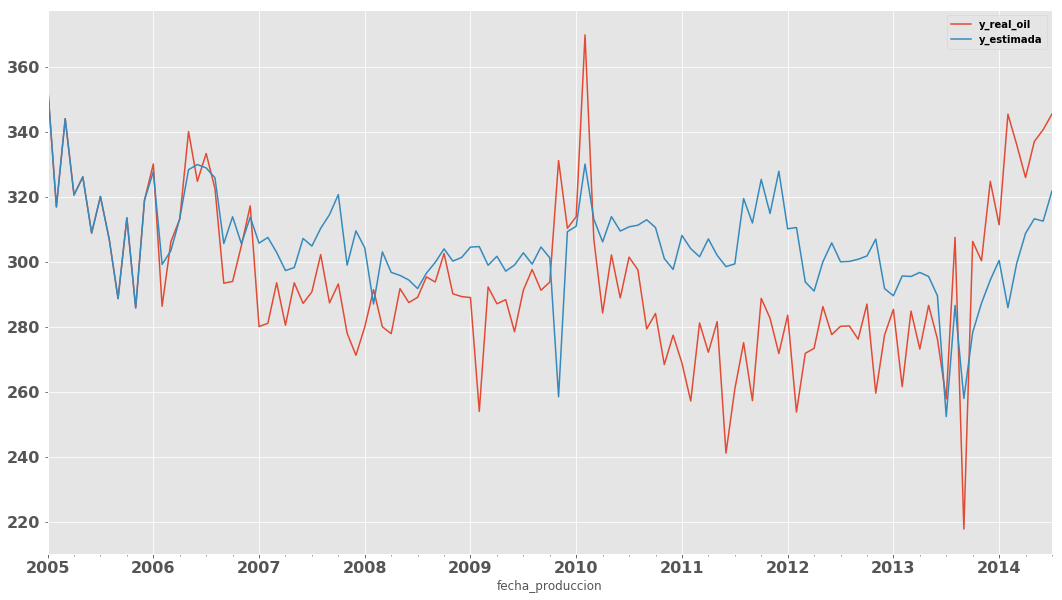

In [554]:
c[['y_real_oil','y_estimada']].plot(figsize=(18,10))

Text(2010-01-01, 23.408767680738976, 'residuo promedio  18.409')

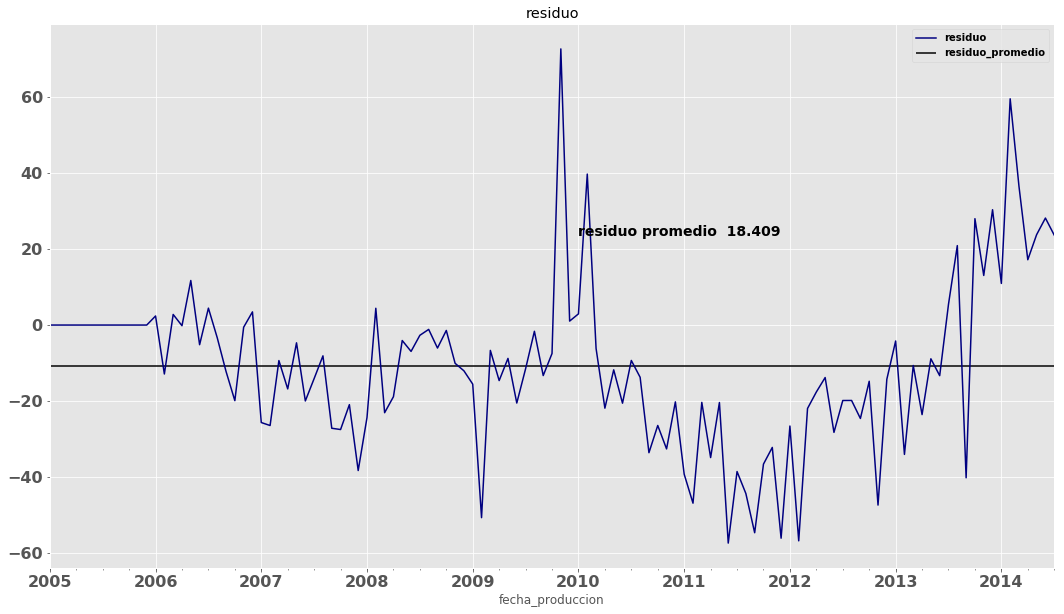

In [555]:
c.residuo.plot(figsize=(18,10),title='residuo', color='navy')
# mi,ma = plt.ylim()
plt.hlines(c.residuo.mean(),'2005-01-01','2015-01-01')
plt.legend(['residuo','residuo_promedio'])
plt.text('2010-01-01',c.residuo.abs().mean()+5,'residuo promedio % 1.3f' %c.residuo.abs().mean(),fontsize=14)

In [556]:
a = df_train[['Pozo','fecha_produccion','y_real_gas_t_1']]
a.columns = ['Pozo','fecha_produccion','y_real_gas']
b = df_prueba[['Pozo','fecha_produccion','y(t-1)_gas']]
b.columns = ['Pozo','fecha_produccion','y_estimada']
c = a.merge(b,on=['Pozo','fecha_produccion'])
c = c.groupby('fecha_produccion')[['y_real_gas','y_estimada']].mean()
c['residuo'] = c.y_real_gas - c.y_estimada

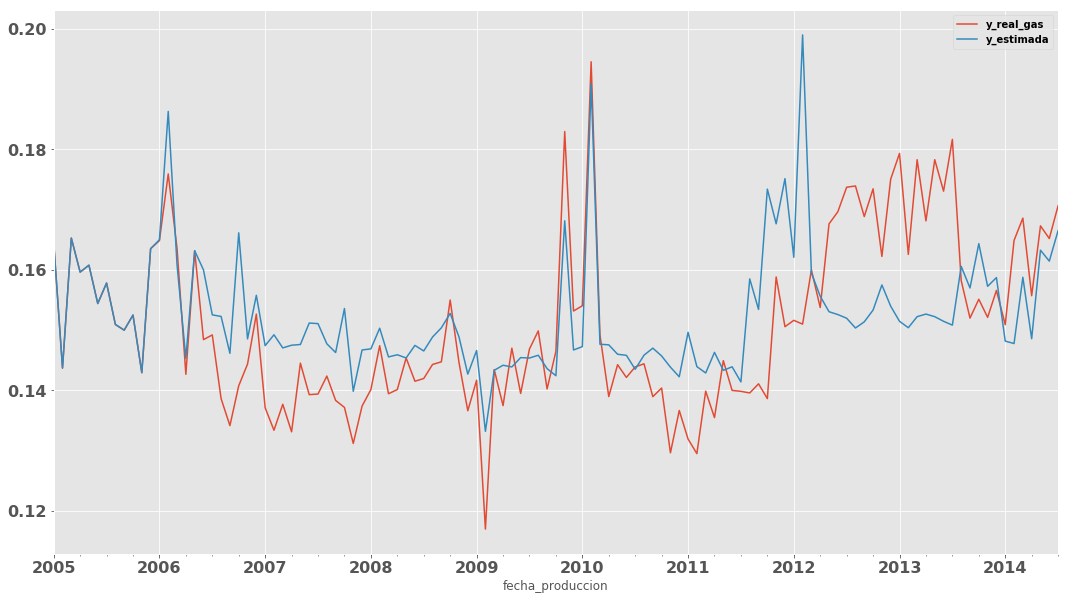

In [557]:
c[['y_real_gas','y_estimada']].plot(figsize=(18,10))

Text(2010-01-01, 0.008581100699252088, 'residuo promedio  0.009')

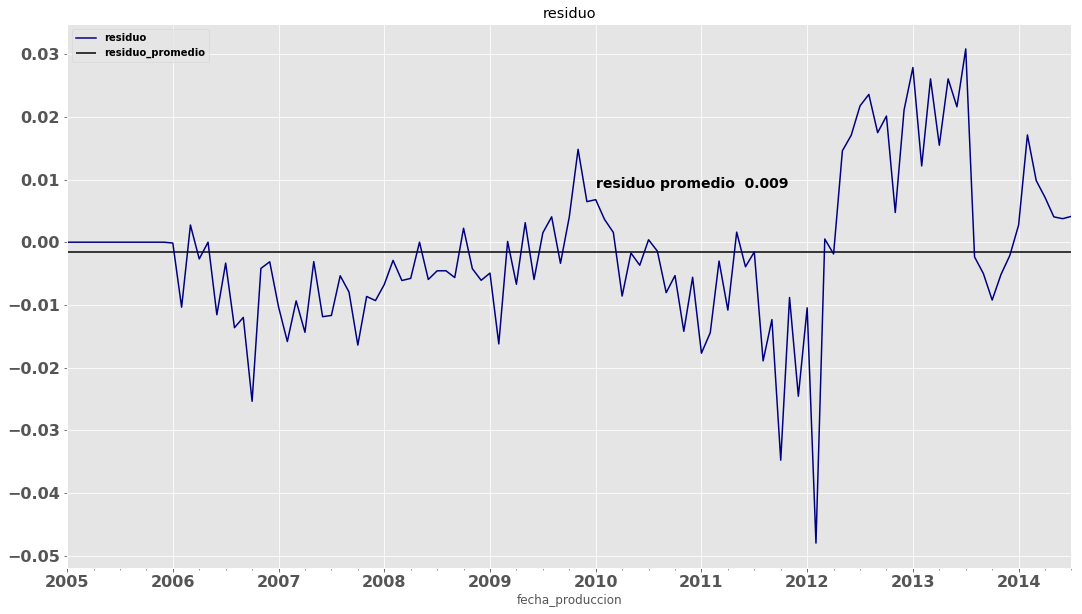

In [563]:
c.residuo.plot(figsize=(18,10),title='residuo', color='navy')
# mi,ma = plt.ylim()
plt.hlines(c.residuo.mean(),'2005-01-01','2015-01-01')
plt.legend(['residuo','residuo_promedio'])
plt.text('2010-01-01',c.residuo.abs().mean(),'residuo promedio % 1.3f' %c.residuo.abs().mean(),fontsize=14)

In [568]:
c_anual = c
c.head(10)

,y_real_gas,y_estimada,residuo
fecha_produccion,,,
2005-01-01,0.164559,0.164559,0.0
2005-02-01,0.143704,0.143704,0.0
2005-03-01,0.165278,0.165278,0.0
2005-04-01,0.159634,0.159634,0.0
2005-05-01,0.160779,0.160779,0.0
2005-06-01,0.154419,0.154419,0.0
2005-07-01,0.157816,0.157816,0.0
2005-08-01,0.150941,0.150941,0.0
2005-09-01,0.150000,0.150000,0.0


In [611]:
c_anual['anio'] = c_anual.index
c_anual['anio'] = c_anual['anio'].dt.year
#c = c.groupby('fecha_produccion')[['y_real_gas','y_estimada']].mean()
c_anual.head(10)

,y_real_gas,y_estimada,residuo,anio
fecha_produccion,,,,
2005-01-01,0.164559,0.164559,0.0,2005
2005-02-01,0.143704,0.143704,0.0,2005
2005-03-01,0.165278,0.165278,0.0,2005
2005-04-01,0.159634,0.159634,0.0,2005
2005-05-01,0.160779,0.160779,0.0,2005
2005-06-01,0.154419,0.154419,0.0,2005
2005-07-01,0.157816,0.157816,0.0,2005
2005-08-01,0.150941,0.150941,0.0,2005
2005-09-01,0.150000,0.150000,0.0,2005


In [612]:
c_anual.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 115 entries, 2005-01-01 to 2014-07-01
Data columns (total 4 columns):
y_real_gas    115 non-null float64
y_estimada    115 non-null float64
residuo       115 non-null float64
anio          115 non-null int64
dtypes: float64(3), int64(1)
memory usage: 4.5 KB


In [619]:
c_prueba = c_anual
#c_prueba = c_prueba.set_index()
#c_prueba.set_index(c_prueba)

#c_prueba.restart_index = True
c_prueba = c_prueba.groupby('anio', as_index = False).cumsum()
c_prueba.head(10)

,y_real_gas,y_estimada,residuo
fecha_produccion,,,
2005-01-01,0.164559,0.164559,0.0
2005-02-01,0.308263,0.308263,0.0
2005-03-01,0.473540,0.473540,0.0
2005-04-01,0.633174,0.633174,0.0
2005-05-01,0.793954,0.793954,0.0
2005-06-01,0.948372,0.948372,0.0
2005-07-01,1.106188,1.106188,0.0
2005-08-01,1.257130,1.257130,0.0
2005-09-01,1.407130,1.407130,0.0


In [620]:
c_prueba.shape

(115, 3)

# Modelo de Gas

Con las mismas variables y metodologia del anterior modelo, entrenamos el modelo de gas. Obteniendo como resultado:

+ $R^2$: 0.8833
+ $R^2$ ajustada$: 0.8588
+ MEA: 0.0066
+ MSE 0.0003
+ RMSE 0.0171

Obteniendo de importancia de variables similar al modelo de Petroleo; de igual manera la prediccion en forecasting es adecuada durante los primeros 5 años de estimacion, posterior a ello crece el error en un 50%

# Entrenamiento

In [ ]:
num_cols = [i for i in df_train.columns if i not in ['Pozo',
            'fecha_produccion','Produccion_barriles_t','Produccion_gasMMpc_t',
            'dummi_pico_bajo','prediction','prediction_oil','prediction_gas']]
num_cols

In [ ]:
x_train, x_test, x_valid, y_train, y_test, y_valid = st.train_test_valid_split(df_train, 
                                                                               num_cols, 'Produccion_gasMMpc_t')

# Conjunto de validacion

In [163]:
y_valid.index.tolist()

[9606,
 832,
 9019,
 3469,
 9679,
 7883,
 9708,
 998,
 10691,
 8758,
 1289,
 3182,
 4207,
 1996,
 623,
 1719,
 193,
 9557,
 2220,
 7843,
 10322,
 4218,
 4881,
 8573,
 9234,
 6103,
 3813,
 7973,
 9257,
 2600,
 5815,
 5651,
 7488,
 7769,
 8669,
 4497,
 8689,
 4011,
 4068,
 5549,
 4955,
 8009,
 10955,
 7764,
 116,
 7530,
 6258,
 5316,
 801,
 740,
 7786,
 3631,
 2582,
 9409,
 2712,
 6231,
 9696,
 2034,
 6953,
 10891,
 6887,
 5423,
 10778,
 3773,
 5011,
 1665,
 10430,
 3700,
 6808,
 8989,
 1111,
 3504,
 5266,
 1799,
 9622,
 1384,
 7991,
 4133,
 4185,
 5943,
 2957,
 2614,
 9356,
 9101,
 7961,
 10747,
 9643,
 7293,
 10207,
 3393,
 9958,
 7102,
 2343,
 10931,
 3905,
 1274,
 7462,
 6465,
 2809,
 5756,
 14,
 10366,
 8393,
 1374,
 1226,
 7075,
 6904,
 877,
 3345,
 2335,
 2762,
 1889,
 9978,
 925,
 867,
 388,
 10895,
 8553,
 8256,
 7988,
 246,
 5154,
 895,
 9353,
 9637,
 3464,
 10759,
 7001,
 10788,
 6094,
 1792,
 3567,
 1810,
 7192,
 8103,
 9185,
 10372,
 1139,
 10477,
 8624,
 3144,
 5954,
 2937,
 10924,
 3425,
 3016,
 10211,
 5003,
 5277,
 9785,
 1958,
 2140,
 1982,
 4962,
 7890,
 5457,
 9168,
 9402,
 544,
 2005,
 5214,
 531,
 8911,
 932,
 6164,
 6007,
 547,
 3862,
 3284,
 3937,
 1749,
 3992,
 1174,
 5523,
 3678,
 163,
 9927,
 6899,
 2068,
 9245,
 9991,
 10684,
 9515,
 5786,
 10018,
 2882,
 3549,
 3143,
 6338,
 9405,
 5546,
 91,
 734,
 2083,
 6067,
 1470,
 3480,
 5770,
 10830,
 6285,
 37,
 10155,
 10762,
 9984,
 6996,
 7698,
 10249,
 538,
 345,
 8389,
 2006,
 2159,
 2896,
 6960,
 6331,
 3124,
 8136,
 10108,
 2872,
 5317,
 7109,
 9769,
 4117,
 9998,
 2208,
 8988,
 2203,
 3397,
 10454,
 8084,
 2390,
 6588,
 3742,
 3212,
 319,
 2636,
 5468,
 6921,
 4159,
 6364,
 8175,
 7836,
 3498,
 2503,
 1434,
 7271,
 7697,
 5061,
 87,
 2685,
 3637,
 8425,
 619,
 8576,
 9451,
 8490,
 2589,
 8649,
 1031,
 10027,
 2042,
 5595,
 8237,
 4582,
 1159,
 9818,
 7685,
 8195,
 6306,
 5553,
 2317,
 4890,
 3680,
 9048,
 1165,
 5062,
 2293,
 6278,
 5721,
 4163,
 9304,
 95,
 5074,
 10110,
 4345,
 7134,
 7956,
 160,
 5359,
 7785,
 7025,
 2901,
 9290,
 2219,
 99,
 10319,
 10368,
 835,
 4900,
 5064,
 6795,
 4249,
 10280,
 1865,
 4996,
 4607,
 8320,
 6043,
 6216,
 4350,
 6610,
 1716,
 4805,
 10051,
 6665,
 5029,
 3281,
 4554,
 8143,
 3562,
 3261,
 4549,
 5040,
 7573,
 9384,
 4903,
 6324,
 1169,
 5171,
 3632,
 7761,
 10571,
 2911,
 6818,
 10914,
 10221,
 10456,
 9746,
 4995,
 9948,
 6609,
 2788,
 9504,
 8778,
 10267,
 3651,
 5230,
 9526,
 4907,
 3407,
 5329,
 5100,
 5615,
 5297,
 3803,
 6496,
 4055,
 9366,
 4958,
 1269,
 8417,
 7645,
 5519,
 6362,
 3739,
 8102,
 9147,
 5293,
 1296,
 7989,
 6561,
 5632,
 55,
 9633,
 2512,
 4799,
 1572,
 1530,
 629,
 10429,
 7644,
 9636,
 2747,
 3448,
 1196,
 3308,
 4132,
 5859,
 7590,
 9142,
 3170,
 3121,
 6441,
 1097,
 2552,
 5825,
 5823,
 5655,
 5289,
 7356,
 8540,
 6019,
 4863,
 10406,
 154,
 9646,
 7526,
 5384,
 4436,
 8145,
 7142,
 1674,
 62,
 10030,
 5098,
 2750,
 4199,
 4227,
 9032,
 5465,
 7875,
 5968,
 1413,
 10139,
 7832,
 5556,
 5429,
 6063,
 10897,
 6225,
 752,
 3028,
 7440,
 2629,
 5646,
 5299,
 8739,
 8236,
 1155,
 3468,
 10756,
 10095,
 6667,
 1002,
 837,
 4904,
 7808,
 8123,
 1061,
 882,
 5089,
 3933,
 1963,
 953,
 7559,
 6578,
 10389,
 4992,
 2123,
 10545,
 7358,
 2107,
 6234,
 5960,
 2707,
 10411,
 1259,
 10448,
 5392,
 2858,
 285,
 3186,
 8182,
 506,
 442,
 2097,
 2922,
 529,
 6971,
 4977,
 1125,
 4801,
 3952,
 7791,
 2639,
 2942,
 7442,
 10421,
 3300,
 4892,
 2085,
 9493,
 8785,
 7797,
 4155,
 2817,
 2112,
 5828,
 346,
 3415,
 149,
 3088,
 8640,
 3781,
 5362,
 1432,
 748,
 3607,
 2772,
 831,
 10172,
 7375,
 8205,
 3677,
 6348,
 1819,
 7548,
 6405,
 7094,
 1404,
 2277,
 7119,
 54,
 5436,
 2453,
 9391,
 1473,
 5945,
 3763,
 23,
 9487,
 10855,
 10283,
 2260,
 10374,
 174,
 7706,
 795,
 4797,
 6839,
 9362,
 1359,
 10583,
 3010,
 8598,
 1166,
 1468,
 2153,
 6188,
 7655,
 4366,
 2703,
 8763,
 3717,
 5239,
 6697,
 6168,
 443,
 10605,
 9066,
 212,
 9510,
 7716,
 3833,
 5421,
 3346,
 8071,
 3470,
 2398,
 1283,
 9486,
 9763,
 2793

# seguimos entrenando

In [164]:
x_train.shape

(7892, 144)

In [165]:
d_train = lgb.Dataset(x_train, y_train)
d_test = lgb.Dataset(x_test, label=y_test)

params = {}
params['learning_rate'] = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'
params['sub_feature'] = 0.5
params['num_leaves'] = 50
params['min_data'] = 1
params['max_depth'] = -1
params['num_iterations'] = 100000

clf = lgb.train(params, d_train, 1000, valid_sets=[d_test], early_stopping_rounds=25,verbose_eval=10000)

Training until validation scores don't improve for 25 rounds.
[10000]	valid_0's l1: 0.0107609
Early stopping, best iteration is:
[12820]	valid_0's l1: 0.0107478


In [166]:
clf.num_trees()

12820

# Evaluacion

In [167]:
y_pred = clf.predict(x_valid)

In [168]:
from sklearn import metrics
def report_evaluation_regression(y_real, y_pred, num_features):
    """Reporte de evaluacion,
    y_real, y_pred=y_estimada,num_features=numero de variables"""
    R2=metrics.r2_score(y_real,y_pred)
    n=len(y_real)
    p=num_features
    r2 = 1-(1-R2)*(n-1)/(n-p-1)
    
    
    print("R^2: %1.4f" % R2)
    
    print("R^2 ajustada$: %1.4f" % r2)
    
    print("MEA: %1.4f" % metrics.mean_absolute_error(y_real,y_pred))
    print("MSE %1.4f" % metrics.mean_squared_error(y_real,y_pred))
    print("RMSE %1.4f" % np.sqrt(metrics.mean_squared_error(y_real,y_pred)))
    

In [169]:
y_valid.mean()

0.15417502278942577

In [170]:
report_evaluation_regression(y_valid, y_pred, x_train.shape[1])

R^2: 0.7324
R^2 ajustada$: 0.6920
MEA: 0.0115
MSE 0.0020
RMSE 0.0453


In [171]:
def yy_plot(y_real, y_pred):
    plt.scatter(y_real, y_pred, alpha=0.5)
    mi2,ma2 = y_real.min(), y_real.max()
    mi1,ma1 = y_pred.min(), y_pred.max()
    plt.plot([mi2,ma2],[mi1,ma1], linestyle='--', color='navy')
    plt.xlabel('Y_real')
    plt.ylabel('Y_estimada')

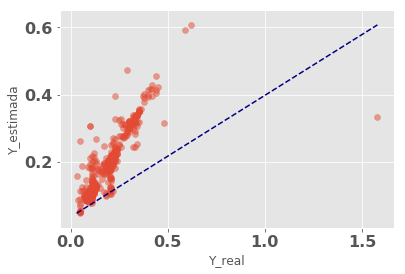

In [172]:
yy_plot(y_valid, y_pred)

## Residuos

In [173]:
res = (y_valid - y_pred) / y_valid

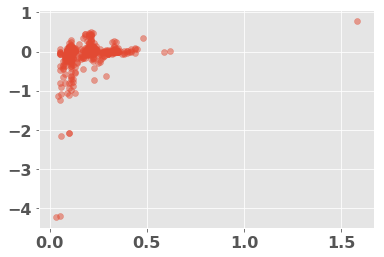

In [174]:
plt.scatter(y_valid, res, alpha=0.5)

In [175]:
res.median() * 100

0.015693427924401426

In [176]:
res.mean() * 100

-3.5071195563585276

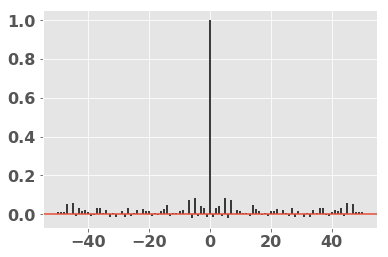

In [177]:
plt.xcorr(res, res,maxlags=50, usevlines=1)
plt.show()

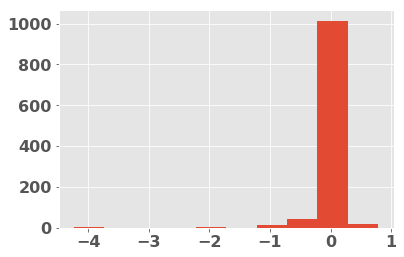

In [178]:
res.hist()

## Autocorrelacion

Blogs indican que es mejor hacer la estimacion de $\hat{y}=P(t)-P(t-1)=\alpha + \sum {\beta X_i} + \epsilon$

Se generan mas variables para ayudarle al modelo

# Interpretacion

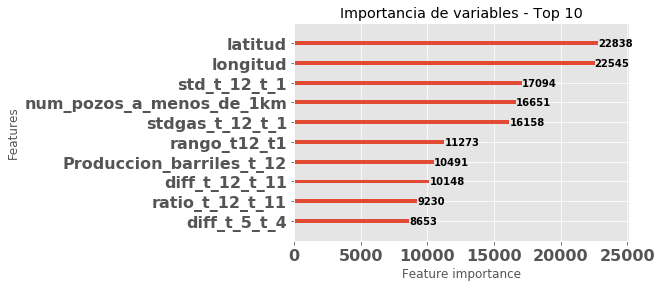

In [179]:
lgb.plot_importance(clf,max_num_features=10, title='Importancia de variables - Top 10')

In [180]:
explainer, shap_values = st.shap_shap(clf, x_valid)

In [181]:
shap.force_plot(explainer.expected_value, shap_values[5,:], x_valid.iloc[5,:])

## Efectos Marginales

In [182]:
a = pd.DataFrame(clf.feature_importance(), index=x_valid.columns,
             columns=['imp']).sort_values('imp')

In [183]:
a.tail(8).index

Index(['diff_t_12_t_11', 'Produccion_barriles_t_12', 'rango_t12_t1',
       'stdgas_t_12_t_1', 'num_pozos_a_menos_de_1km', 'std_t_12_t_1',
       'longitud', 'latitud'],
      dtype='object')

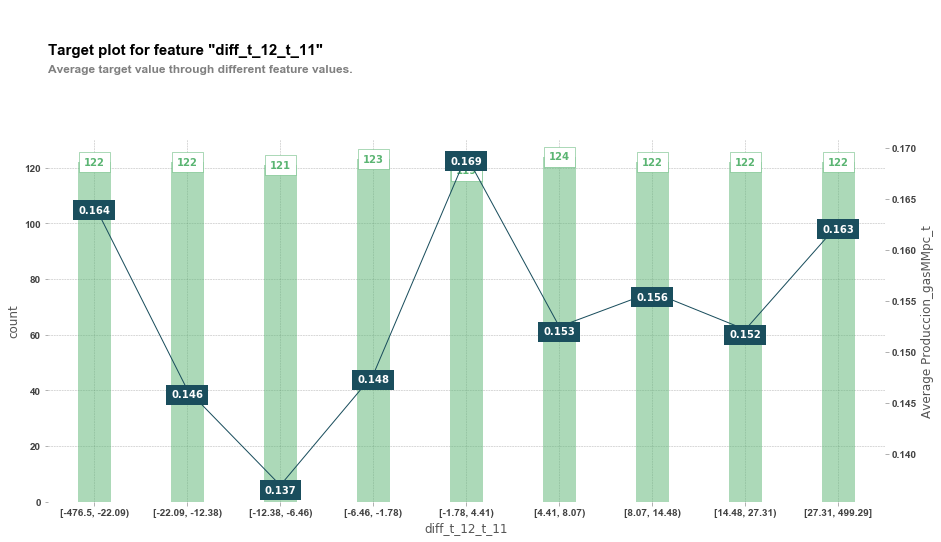

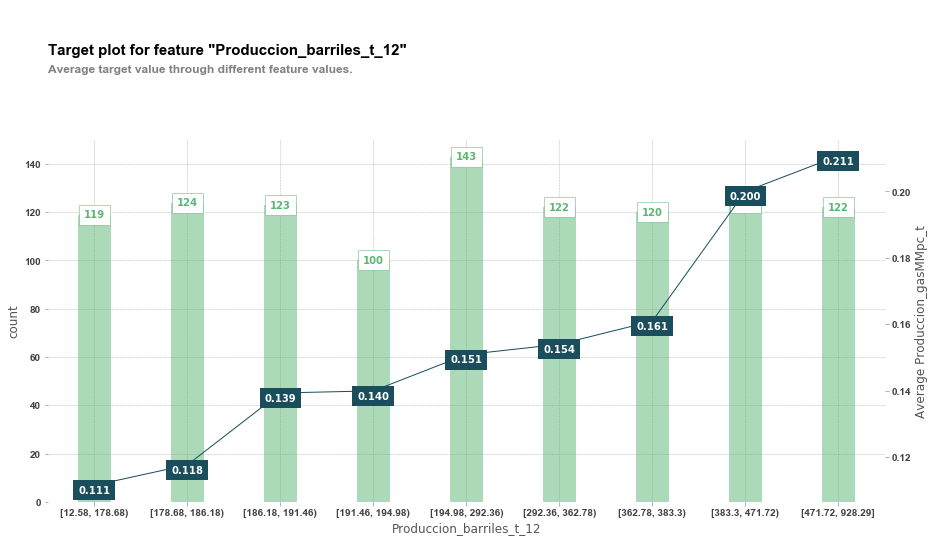

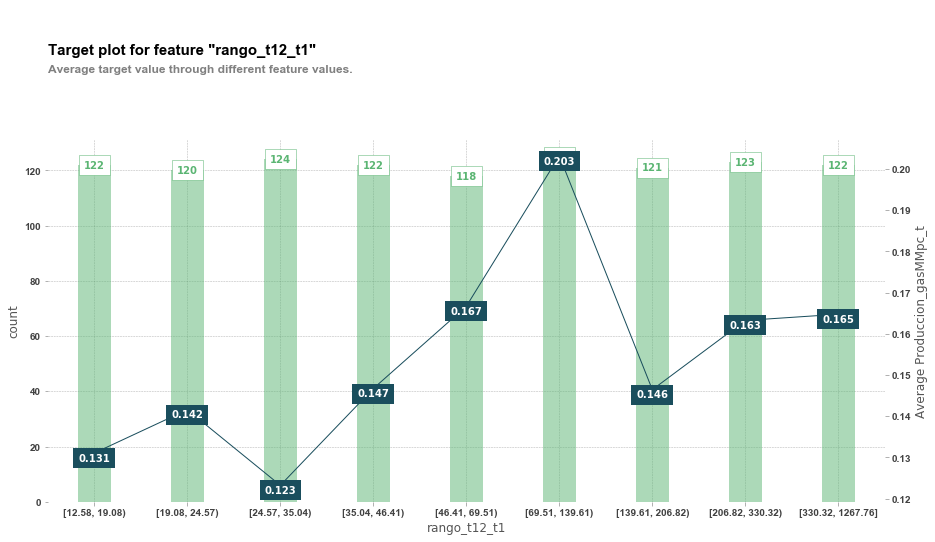

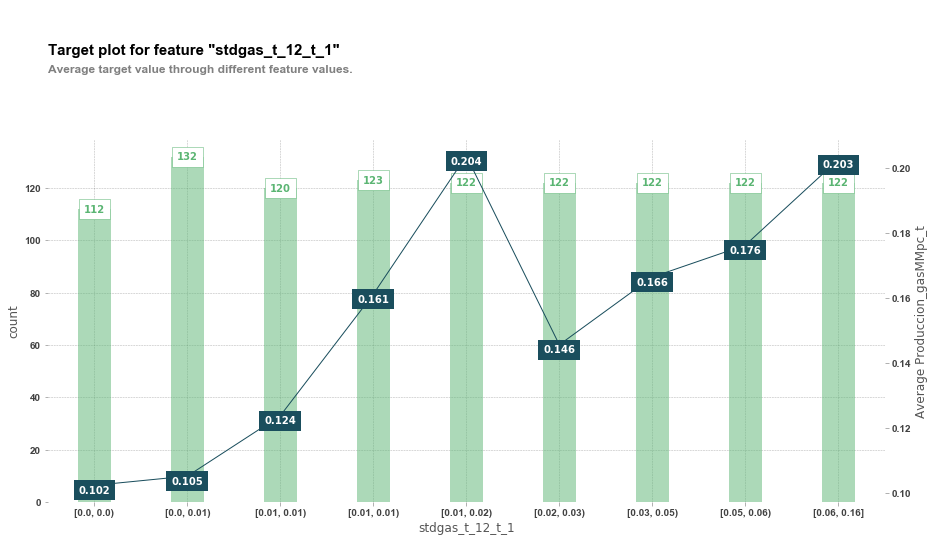

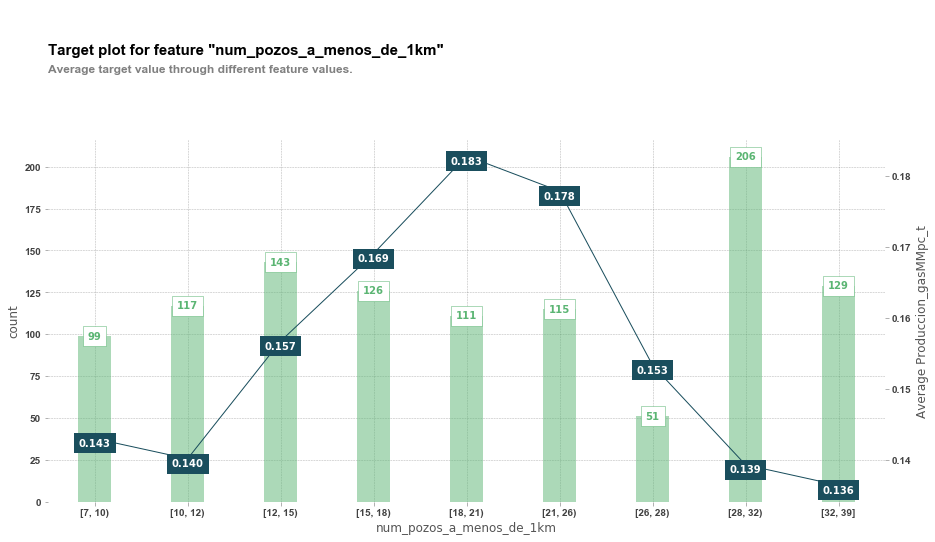

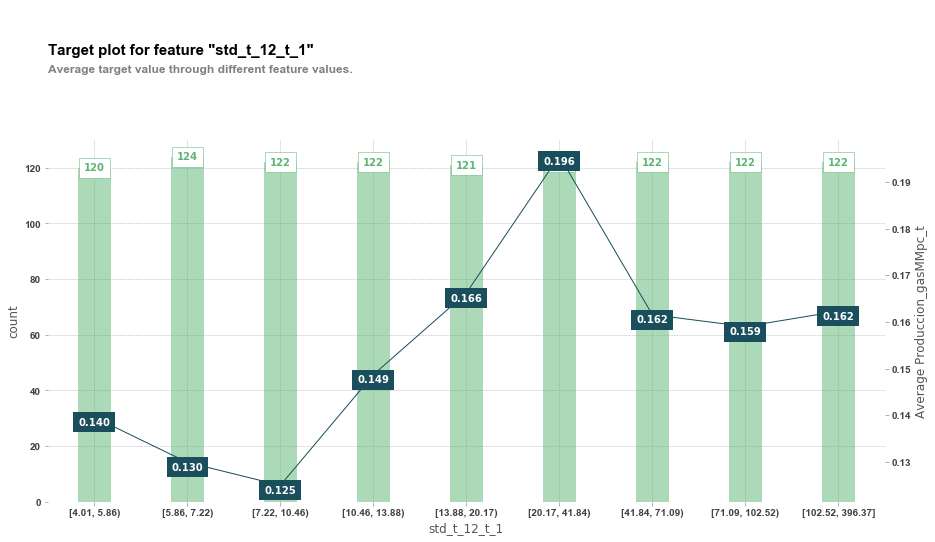

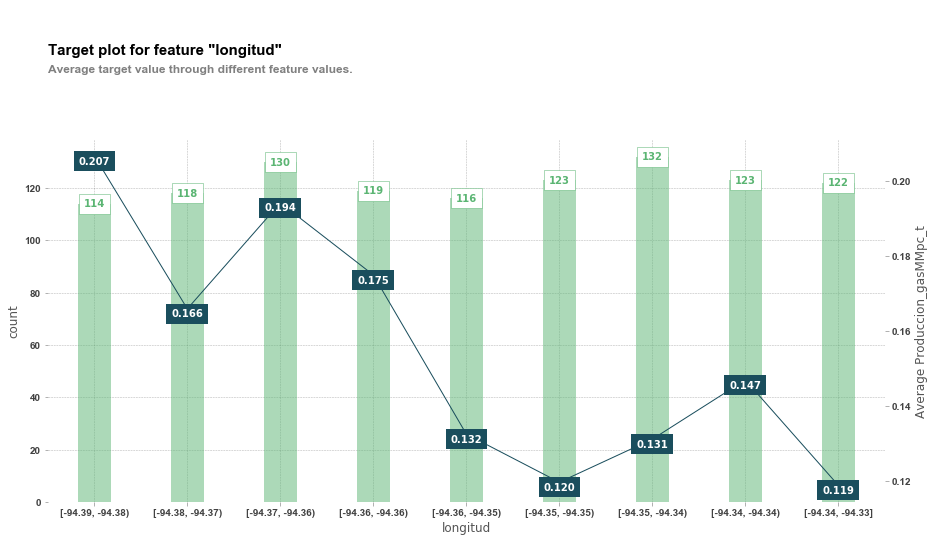

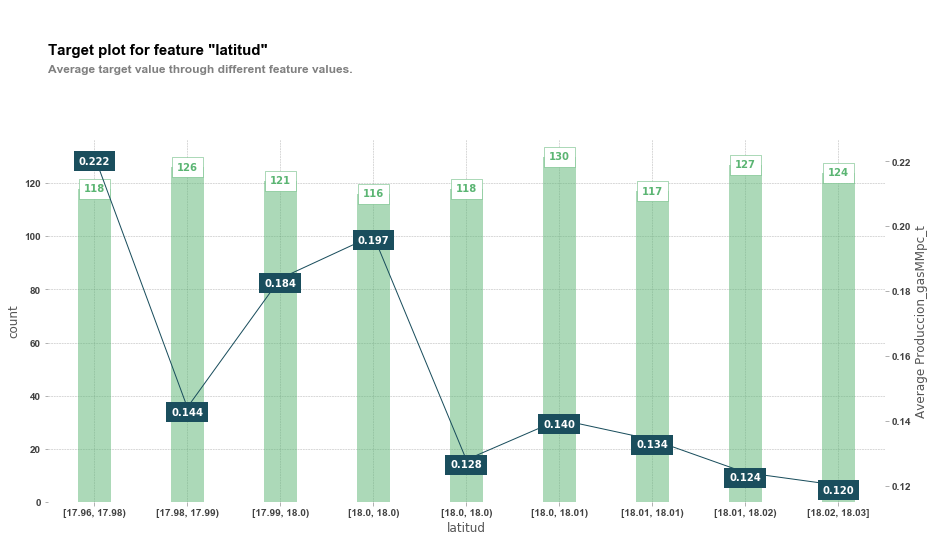

In [184]:
for col in a.tail(8).index:
    fig, axes, summary_df = info_plots.target_plot(
        df=pd.concat([x_valid,y_valid],1)
        , feature=col, 
        feature_name=col, 
        target='Produccion_gasMMpc_t'
    )

## Pendiente interpretar los de shap

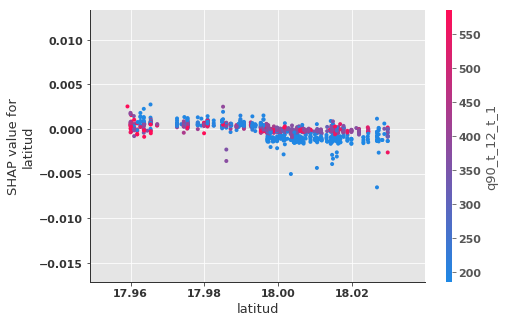

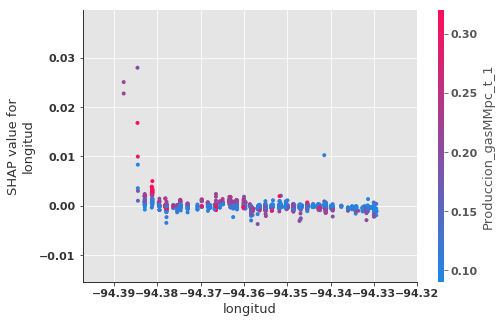

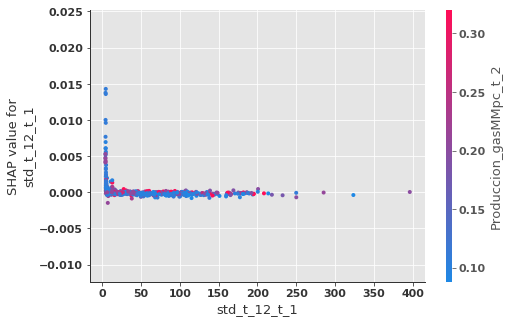

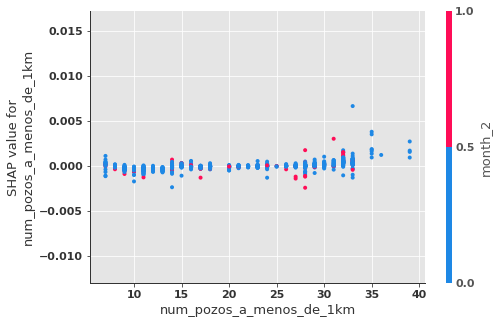

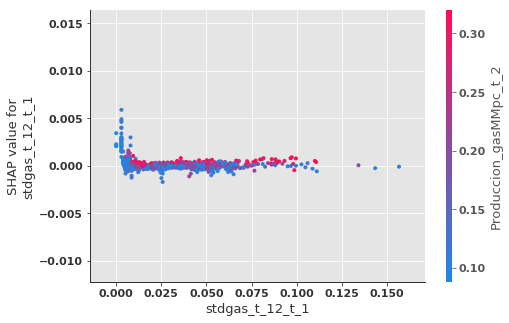

In [185]:
for col in a.sort_values('imp',ascending=False).head(5).index:
    shap.dependence_plot(col, shap_values, x_valid)

# Guardado de mejor modelo

In [186]:
joblib.dump(clf, 'light_gbm_gas_01-08-2019.pkl')
# load model
# gbm_pickle = joblib.load('light_gbm_31-07-2019.pkl')

['light_gbm_gas_01-08-2019.pkl']

In [187]:
# carga de modelo
# gbm_pickle = joblib.load('modelos/light_gbm_31-07-2019.pkl')

# Check de pozos aleatorios

In [188]:
idx = df_train.Pozo.sample(10)

In [189]:
index = df_train[df_train.Pozo.isin(idx)].groupby(['Pozo','fecha_produccion']).Produccion_gasMMpc_t.first().index

In [190]:
validacion = df_train[df_train.Pozo.isin(idx)].groupby(['Pozo','fecha_produccion']).Produccion_gasMMpc_t.first().unstack(0)

In [191]:
prediction = clf.predict(df_train[df_train.Pozo.isin(idx)][num_cols])

In [192]:
prediccion_validacion = pd.DataFrame(prediction,columns=['prediction']).set_index(index).unstack(0)

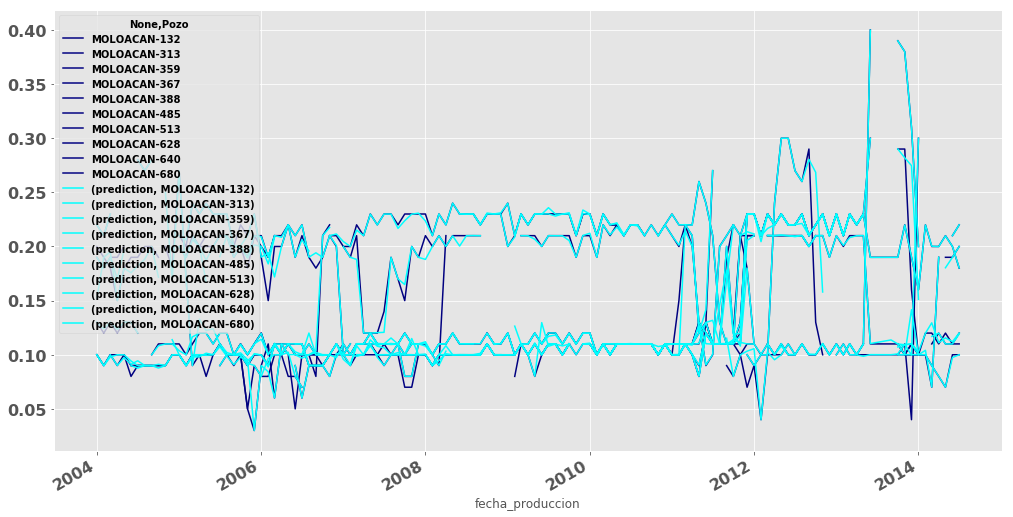

In [193]:
ax = validacion.plot(figsize=(17,9),color='navy')
prediccion_validacion.plot(ax = ax,color='cyan')

In [194]:
# pd.merge(validacion,prediccion_validacion,right_index=True, left_index=True).iplot()

# Pozo promedio

In [195]:
preds = clf.predict(df_train[num_cols])
real = df_train.Produccion_gasMMpc_t

In [196]:
df_train['prediction_gas'] = preds

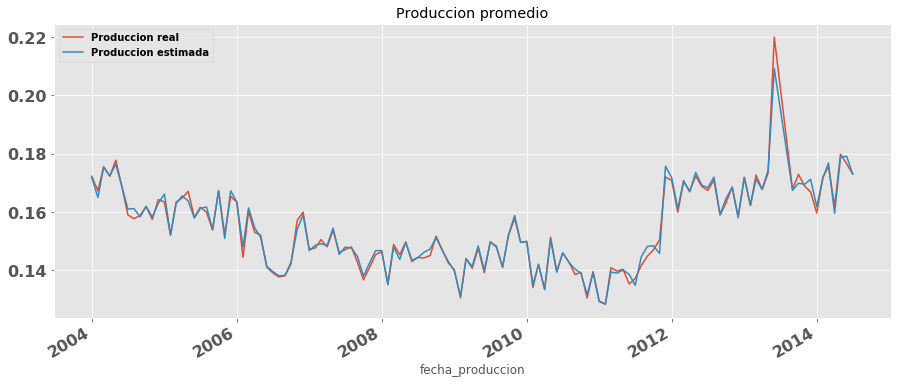

In [197]:
df_train.groupby('fecha_produccion')[['Produccion_gasMMpc_t','prediction_gas']].mean().plot(
    figsize=(15,6), title='Produccion promedio')
plt.legend(['Produccion real', 'Produccion estimada'])

# Pozo Tipo Promedio Base 0
Seleccionar pozos que tengan al menos 10 anios de vida

En promedio tienen 110 mediciones, es decir, al menos 9 anios de vida

In [198]:
 df_train.groupby('Pozo').fecha_produccion.count().median()

84.5

In [199]:
pozos_vivos = df_train.groupby('Pozo').fecha_produccion.count()[
    df_train.groupby('Pozo').fecha_produccion.count() > 110].index

In [200]:
df_vivos = df_train[df_train.Pozo.isin(pozos_vivos)]

In [201]:
df_vivos = df_vivos[df_vivos.fecha_produccion > '2003-12-01']

In [202]:
a = df_vivos.groupby('Pozo').fecha_produccion.min()
idx_a = a[a=='2004-01-01'].index

In [203]:
df_vivos = df_vivos[df_vivos.Pozo.isin(idx_a)]

In [204]:
# ax = df_vivos.groupby('fecha_produccion')[['Qomes_b_t','prediction']].mean().plot(
#     figsize=(15,6), title='Produccion promedio en un pozo tipo base 0',linewidth=4.0)

# ax.fill_between(sorted(df_vivos.fecha_produccion.unique()), 
#                 df_vivos.groupby('fecha_produccion')['prediction'].mean(),
#                 df_vivos.groupby('fecha_produccion')['prediction'].quantile(0.90),
#                alpha=0.3, color='navy')

# ax.fill_between(sorted(df_vivos.fecha_produccion.unique()), 
#                 df_vivos.groupby('fecha_produccion')['prediction'].quantile(0.10),
#                 df_vivos.groupby('fecha_produccion')['prediction'].mean(),
#                alpha=0.3, color='navy')

# plt.legend(['Produccion real', 'Produccion estimada','quantil-90','quantil-10'])

In [205]:
df_vivos2 = df_vivos.groupby('fecha_produccion')[['Produccion_gasMMpc_t','prediction_gas']].mean()
df_vivos2["Qomes_b_t_q90"] = df_vivos.groupby('fecha_produccion')['Produccion_gasMMpc_t'].quantile(0.90)
df_vivos2["Qomes_b_t_q10"] = df_vivos.groupby('fecha_produccion')['Produccion_gasMMpc_t'].quantile(0.10)
df_vivos2["prediccion_q90"] = df_vivos.groupby('fecha_produccion')['prediction_gas'].quantile(0.90)
df_vivos2["prediccion_q10"] = df_vivos.groupby('fecha_produccion')['prediction_gas'].quantile(0.10)
df_vivos2['residuo'] = df_vivos2.Produccion_gasMMpc_t - df_vivos2.prediction_gas

In [206]:
df_vivos2.iplot(title='Perfiles de pozos con su estimacion')

In [207]:
df_vivos2.to_csv("perfiles_pozo_gas.csv")

# BD 5 Presidentes

In [185]:
db_prod_mol = pd.read_csv('datos/DB_prod_moloacan.csv')
db_prod_mol.columns = db_prod_mol.columns.str.replace(" ","_").str.replace(
    "(","").str.replace(")","").str.replace(".","").str.replace('á',"a").str.replace('é',"e").str.replace(
    'í',"i").str.replace('ó',"o").str.replace('ú',"u")
# transfromaciones
db_prod_mol['Qo_mes_b'] = db_prod_mol['Qo_mes_b'].str.replace(',', '').astype(float)
db_prod_mol['Qw_mes_b'] = db_prod_mol['Qw_mes_b'].str.replace(',', '').astype(float)
db_prod_mol['RGA_m3/m3'] = db_prod_mol['RGA_m3/m3'].str.replace(',', '').astype(float)
db_prod_mol["Pozo"] = db_prod_mol.Pozo.str.replace("Á","A")